# Final Project: Methane Combustion in a Countercurrent Configuration

# Introduction
The goal of this project is to simulate the combustion of methane in air in a counter-flow configuration. Methane and air are injected facing each other, flowing in opposite directions, and nitrogen is injected in the same manner at the top and bottom of the simulation box to dilute and shield the two other gases from external disturbances. The simulation is carried out in a 2 mm by 2 mm box with a slip wall on the left, an open boundary on the right, and two no-slip walls at the top and bottom outside the injection regions.

The simulation of this phenomenon will be done in several steps to ensure that each calculation is correct. First, the objective is to solve the Navier–Stokes equations using a first-order fractional-step method in order to determine the velocity components u and v (along x and y, respectively) throughout the reaction. Once the velocity field is obtained, we can then compute the strain rate a, defined as $a=dv/dy$, on the left boundary (the slip wall) only. The strain rate is very useful for analyzing fluid–wall interactions in more detail, for example to determine the flow regime or the shear forces involved.

In the second stage, the goal will be to simulate only the transport of nitrogen particles. Since nitrogen is a spectator species in the combustion reaction, it is merely transported and not consumed. It also does not influence temperature, meaning that once the velocity components have been computed, we can directly simulate the transport of nitrogen. The final aim of this step is to determine the diffusive zone of nitrogen along the left boundary of the simulation box. Knowing this zone is useful for studying concentration profiles or for improving and optimizing processes (in our case, optimizing combustion).

Finally, the ultimate goal will be to simulate the overall transport of all species involved in the chemical reaction and thus determine the evolution of temperature over time during combustion. This will make it possible to determine the maximum temperature reached during the reaction. Based on available data, for an ideal combustion such as the one we are simulating, the maximum temperature should lie between 1700 and 2500 K.

# Part 1: Calculation of the Velocity Components

### 1 - La théorie : Les équations de Navier-Stokes et les méthodes par pas fractionnés

The goal of this section is to compute the velocity components at each time step in order to understand how the particles move (and later to solve their transport equations). To do this, we solve the Navier–Stokes equations, which are written as:

\begin{align}
     \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{1}{\rho}\frac{\partial P}{\partial x} + \nu (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) \\
     \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{1}{\rho}\frac{\partial P}{\partial y} + \nu (\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2})\\
     \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} & = 0
\end{align}

Here, $\rho = 1.1614 kg/m^3$ is the fluid density, $\nu = 15e-6 m^2/s$ is the kinematic viscosity, and $P$ is the pressure.
To solve this system, we use a fractional-step method. This means that to compute the velocity at time $t+1$, we first compute an intermediate velocity $u^*$ that does not include the pressure term, then solve the Poisson equation to obtain the pressure using this intermediate velocity. Finally, the velocity at time $t+1$ is obtained as the sum of the pressure gradient correction and the intermediate velocity. We use index i for the x-component, j for the y-component, and  n for the time step. The intermediate velocity is written as: 

\begin{equation}
    u^{*}_{i,j} = u^{n}_{i,j} - \frac{dt}{2dx} (u^{n}_{i,j} \times (u^{n}_{i+1,j} - u^{n}_{i-1,j}) + v^{n}_{i,j} \times (u^{n}_{i,j+1} - u^{n}_{i,j-1})) + \nu  \frac{dt}{dx^2}  (u^{n}_{i-1,j} - 4 u^{n}_{i,j} + u^{n}_{i+1,j} + u^{n}_{i,j-1} +u^{n}_{i,j+1})
\end{equation}

The same discretization applies to $v^*$ Once the intermediate velocity is computed, we can determine the pressure. We recall the Poisson equation: :

\begin{equation} 
    \Delta P = \frac{\rho}{dt} \times (\frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y})
\end{equation}

The Poisson equation can then be solved as a linear system of the form $Ap=b$, where A is the matrix associated with the Laplacian operator, and b is the right-hand side, here $1/dt \times (\frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y})$. Once the pressure is computed, we can finally write: :

\begin{align}
    & u^{n+1}_{i,j} = u^{*}_{i,j} - \frac{dt}{2dx} \times \frac{1}{\rho} \times (\frac{\partial P}{\partial x}) \\
    & v^{n+1}_{i,j} = v^{*}_{i,j} - \frac{dt}{2dx} \times \frac{1}{\rho} \times (\frac{\partial P}{\partial y}) 
\end{align}

### 2 - The code and the simulation

In [40]:
#Importing the necessary libraries
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [41]:
#Definition of the problem constants
#All values are converted to the SI system
Lx = 0.002 #m 
Nx = 50 
dx = Lx/(Nx - 1)
Nt = 1000
Tf = 0.01#s
dt = Tf/(Nt - 1)
nu = 15e-6 #m^2/s
D = 15e-6 #m^2/s
a = 15e-6 #m^2/s
rho = 1.1614 #kg/m^3
cp = 1200 #J/kg.K

In [42]:
# Check whether Tf is sufficient to reach steady state
def verif_Tf_steady_state(Nx, Lx, Tf):
    
    # Time needed to cross the box at each velocity
    t1 = Lx / 1       # Time for the fast velocity
    t2 = Lx * (1 - 1/4) / 0.2   # Time for the slow velocity
    
    # Check whether Tf is greater than the crossing time at the slow velocity
    if Tf >= t2:
        return "Steady state can be reached."
    else:
        return "Steady state cannot be reached."

print(verif_Tf_steady_state(Nx, Lx, Tf))

Steady state can be reached.


In [43]:
# CFL condition check
def CFL(dx, dt, nu):
    # Diffusion CFL
    dt_diff = dx**2 * 0.5 / nu
    
    # Advection CFL
    dt_adv = min(dx * 0.5, 0.5 * dx / 2) #2 approx max velocity
    
    # Verification
    CFL_ok = dt <= min(dt_diff, dt_adv)
    print(f" Time step: {dt:.6f}")
    print(f" Spatial step: {dx:.6f}")
    return f"The CFL condition is ({CFL_ok})."

print(CFL(dx, dt, nu))


 Time step: 0.000010
 Spatial step: 0.000041
The CFL condition is (True).


I use a single index $k$ k, defined as $k = i+j \times N_x$, to keep the data consistent across all arrays. Our velocities u,v and our pressure p are therefore not 2D $N_x\times N_x$ matrices at each time step, but 1D vectors of size $N^2$. This prevents confusion due to Python’s convention where the first index corresponds to y and the second to x, which is the opposite of the mathematical notation. All vectors therefore have size $N^2$, and the Laplacian matrix A has dimensions $(N_x^2 \times N_x^2)$. For example, the x-velocity vector is organized as follows:

$\mathbf{U} = \left( u_{0,0}, u_{1,0}, \ldots, u_{n,0}, u_{0,1}, \ldots, u_{i,j}, u_{i+1,j}, \ldots \right)^T
$

In [44]:
# Definition of the velocity matrix V (in y-direction) at time t=0
# x = i , y = j
# Definition of the index k which gives consistent coordinates in all our arrays (because I get mixed up with the fact that x = j and y = i in Python)
def k(i, j):
    return i + j*Nx

# Definition of the vector V0, the vector corresponding to the velocity v (in y-direction) at t=0
def V0_cond(Nx):
    V0 = np.zeros((Nx*Nx))
    for i in range(Nx):      # x becomes the row index
        for j in range(Nx):  # y becomes the column index
            if j == 0:  # bottom boundary
                if 0 <= i < Nx//4:
                    V0[k(i, j)] = 1
                if Nx//4 <= i < Nx//2:
                    V0[k(i, j)] = 0.2
            if j == Nx-1:  # top boundary
                if 0 <= i < Nx//4:
                    V0[k(i, j)] = -1
                if Nx//4 <= i < Nx//2:
                    V0[k(i, j)] = -0.2
    return V0


# Function to compute u* (dx = dy).
def u_etoile(u0, v0, dx, dt, Nx):
    ustar, vstar = np.empty((Nx*Nx)), np.empty((Nx*Nx))
    u, v = np.empty((Nx*Nx)), np.empty((Nx*Nx))
    un, vn = u0.copy(), v0.copy()
    mu = dt / (2*dx)
    mu2 = dt / dx**2
    for i in range(Nx):
        for j in range(Nx):
            # applying boundary conditions
            if i == 0:  # left boundary
                u[k(i, j)] = u0[k(i, j)]
                v[k(i, j)] = v0[k(i, j)]
            elif i == Nx-1:  # right boundary
                u[k(i, j)] = u0[k(i, j)]
                v[k(i, j)] = v0[k(i, j)]
            elif j == 0:  # bottom boundary
                u[k(i, j)] = u0[k(i, j)]
                v[k(i, j)] = v0[k(i, j)]
            elif j == Nx-1:  # top boundary
                u[k(i, j)] = u0[k(i, j)]
                v[k(i, j)] = v0[k(i, j)]
            else:
                u[k(i, j)] = un[k(i, j)] - mu * (un[k(i, j)] * (un[k(i+1, j)] - un[k(i-1, j)]) + (vn[k(i, j)] * (un[k(i, j+1)] - un[k(i, j-1)]))) + nu * mu2 * ((un[k(i+1, j)] - 2*un[k(i, j)] + un[k(i-1, j)]) + un[k(i, j+1)] - 2*un[k(i, j)] + un[k(i, j-1)])
                v[k(i, j)] = vn[k(i, j)] - mu * (un[k(i, j)] * (vn[k(i+1, j)] - vn[k(i-1, j)]) + (vn[k(i, j)] * (vn[k(i, j+1)] - vn[k(i, j-1)]))) + nu * mu2 * ((vn[k(i+1, j)] - 2*vn[k(i, j)] + vn[k(i-1, j)]) + vn[k(i, j+1)] - 2*vn[k(i, j)] + vn[k(i, j-1)])
    return u, v
    
# Definition of the matrix A to solve Ap = b
def A_matrix(Nx, dx):
    N = Nx**2
    A = np.zeros((N, N))
    for i in range(Nx):
        for j in range(Nx):
            if i == 0:  # left boundary
                A[k(i, j), k(i, j)] = -1/dx
                A[k(i, j), k(i, j)+1] = 1/dx
            elif i == Nx-1:  # right boundary
                A[k(i, j), k(i, j)] = 1
            elif j == 0:  # bottom boundary
                A[k(i, j), k(i, j)] = -1/dx
                A[k(i, j), k(i, j)+Nx] = 1/dx
            elif j == Nx-1:  # top boundary
                A[k(i, j), k(i, j)] = 1/dx
                A[k(i, j), k(i, j)-Nx] = -1/dx
            else:  # interior of the matrix
                A[k(i, j), k(i, j)] = -4/dx**2
                A[k(i, j), k(i, j)-1] = 1/dx**2
                A[k(i, j), k(i, j)+1] = 1/dx**2
                A[k(i, j), k(i, j)+Nx] = 1/dx**2
                A[k(i, j), k(i, j)-Nx] = 1/dx**2
    return A
    
# Definition of the right-hand side
def b_secondmember(u_star, v_star, Nx, dx):
    b = np.zeros(Nx*Nx)
    mu = 1/(2*dx*dt)
    for i in range(Nx):
        for j in range(Nx):
            if i == 0:      # left boundary
                b[k(i, j)] = 0
            elif i == Nx-1:  # right boundary
                b[k(i, j)] = 0
            elif j == 0:    # bottom boundary
                b[k(i, j)] = 0
            elif j == Nx-1:  # top boundary
                b[k(i, j)] = 0
            else:
                b[k(i, j)] = mu * ((u_star[k(i+1, j)] - u_star[k(i-1, j)]) + (v_star[k(i, j+1)] - v_star[k(i, j-1)]))
    return b

def Poisson_direct(A, b):
    x = np.linalg.solve(A, b)
    return x


# Definition of the initial conditions for V, U and P
U0 = np.zeros((Nx*Nx))
V0 = V0_cond(Nx)
P0 = np.zeros((Nx*Nx))

# Simulation using fractional steps (x = j, i = y)
def fractional_step(u0, v0, p0, dt, dx, nu, Nt, Nx, rho):
    # Creation of arrays to store the values
    u, v, p = np.zeros((Nx*Nx, Nt)), np.zeros((Nx*Nx, Nt)), np.zeros((Nx*Nx, Nt))
    # Initial conditions
    u[:, 0], v[:, 0], p[:, 0] = U0.copy(), V0.copy(), P0.copy()
    mu = dt/(2*dx)
    A = A_matrix(Nx, dx)
    r = np.zeros(Nt)
    print("Condition number of the matrix =", round(np.linalg.cond(A), 0))
    for n in range(1, Nt):
        u_star, v_star = u_etoile(u[:, n-1], v[:, n-1], dx, dt, Nx)
        b = b_secondmember(u_star, v_star, Nx, dx)
        p[:, n] = Poisson_direct(A, b)
        # 2 = Euclidean norm
        r[n] = (np.linalg.norm(b - A @ p[:, n], 2) / np.linalg.norm(b, 2))
        for i in range(1, Nx-1):
            for j in range(1, Nx-1):
                u[k(i, j), n] = u_star[k(i, j)] - mu / rho * (p[k(i+1, j), n] - p[k(i-1, j), n])
                v[k(i, j), n] = v_star[k(i, j)] - mu / rho * (p[k(i, j+1), n] - p[k(i, j-1), n])
        for i in range(Nx):
            for j in range(Nx):
                # Boundary conditions
                if i == 0:  # left boundary
                    u[k(i, j), n] = 0
                    v[k(i, j), n] = v[k(i+1, j), n]
                elif i == Nx-1:  # right boundary
                    u[k(i, j), n] = u[k(i, j-1), n]
                    v[k(i, j), n] = v[k(i, j-1), n]
                elif j == 0:  # bottom boundary
                    u[k(i, j), n] = 0
                    v[k(i, j), n] = 0
                    if 0 <= i < Nx//4:
                        v[k(i, j)] = 1
                    if Nx//4 <= i < Nx//2:
                        v[k(i, j)] = 0.2
                elif j == Nx-1:  # top boundary
                    u[k(i, j), n] = 0
                    v[k(i, j), n] = 0
                    if 0 <= i < Nx//4:
                        v[k(i, j)] = -1
                    if Nx//4 <= i < Nx//2:
                        v[k(i, j)] = -0.2
    print("The average residual is =", round(np.mean(r), 16))
    return p, u, v

# Associated results
p, u, v = fractional_step(U0, V0, P0, dt, dx, nu, Nt, Nx, rho)


Condition number of the matrix = 34607898237.0
The average residual is = 4.4e-15


The conditioning of a matrix indicates how sensitive it is to errors. In this case, matrix A is very poorly conditioned because its value is very far from 1, meaning that even a very small error in the input can significantly affect the resulting pressure vector p. This is why the direct solving method provided by NumPy is the most suitable here: iterative convergence methods require a very large number of iterations, and may even diverge because of this poor conditioning. It is possible to apply a preconditioning step to reduce the matrix conditioning (such as using a conjugate gradient method), but this requires more computational power, which I do not really have. The direct solution using linalg.solve yields an average relative residual of $10{-14}, which is very satisfactory and shows that this computation strategy performs well for our case.

We will now use the pressure variation to determine at what point the steady state is reached. To do this, we look at when the pressure variation between time step $n$ and time step $n+1$ becomes smaller than $10^{-8}$. This threshold is arbitrary, but small enough to consider that steady-state conditions are achieved

In [45]:
# Determination of the time step from which we consider that steady state is reached
def steady_time(Nx, Nt, p, epsilon = 1e-6):
    # We initialize the sum of p to Nx*Nx to ensure it starts large
    Ysum = Nx*Nx
    for n in range(1, Nt):
        Ysum_courant = np.sum(p[:, n])  # Sum of all pressure values at time n
        Ydiff = abs(Ysum_courant - Ysum) / Ysum_courant  # Difference between the sums at n and n-1, normalized by the sum at n
        Ysum = Ysum_courant  # The sum at time n-1 becomes the current sum
        if Ydiff < epsilon:  # If the difference is smaller than 1e-6, we stop the loop and return the values
            Nstat = n
            tstat = n*dt
            return Nstat, tstat
        
Nstat, tstat = steady_time(Nx, Nt, p, epsilon = 1e-8)
print("Steady state is reached at t =", round(tstat, 4), "s at iteration", Nstat)

Steady state is reached at t = 0.0067 s at iteration 671


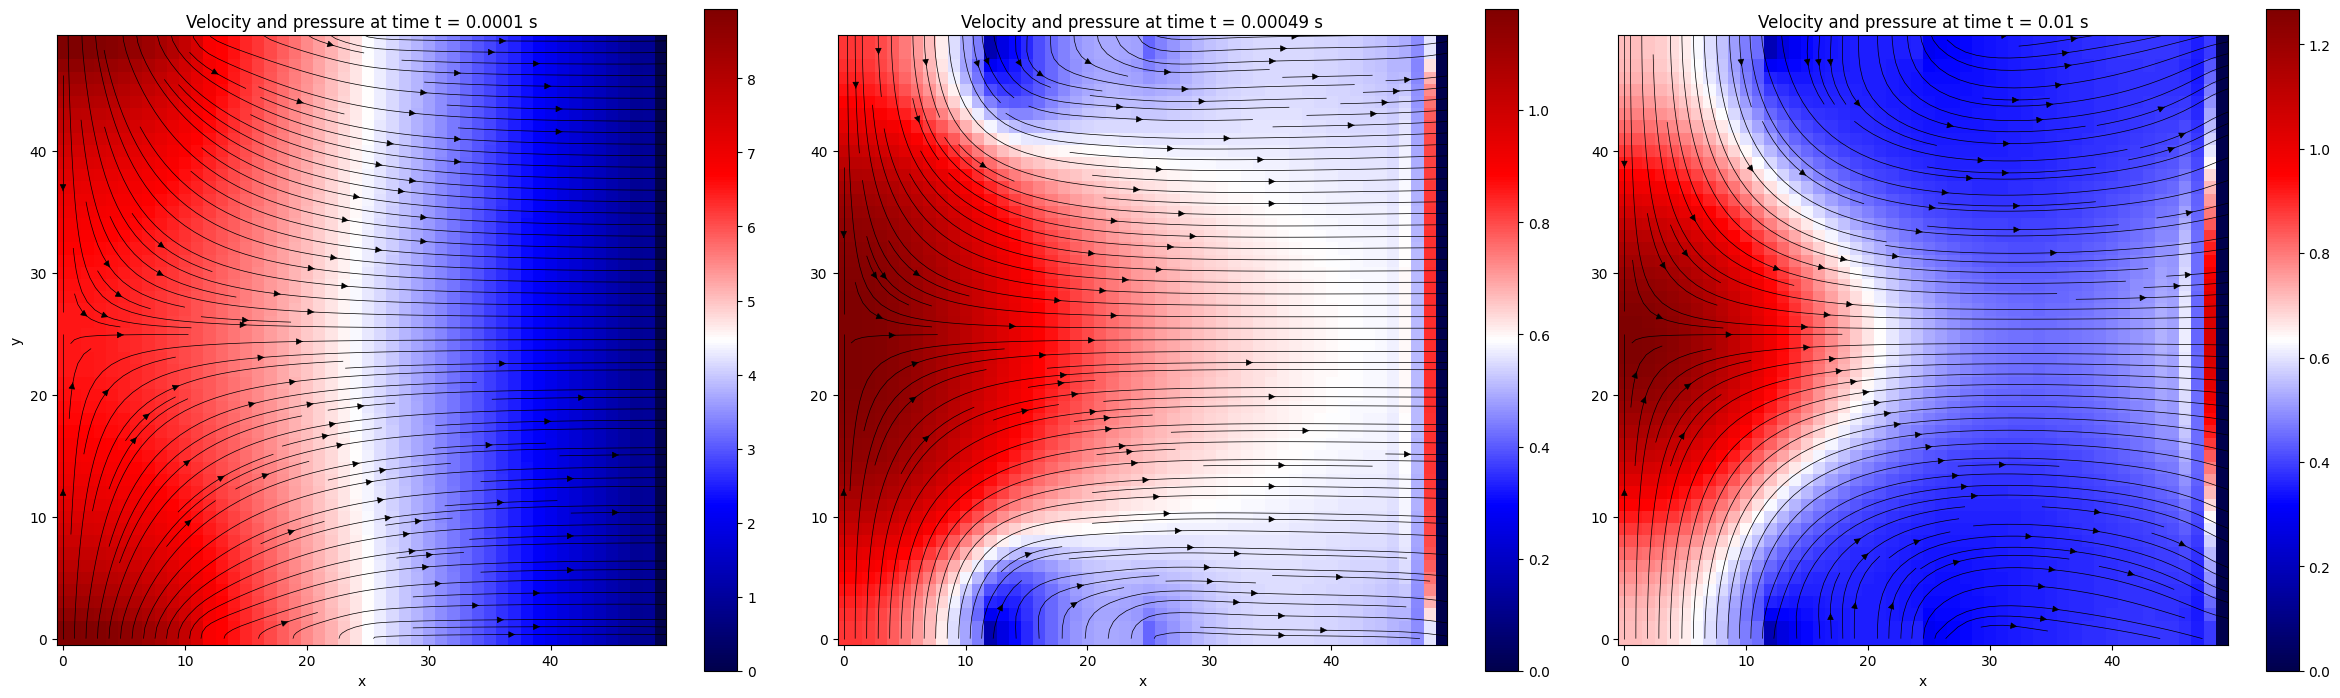

In [46]:
# Evolution of velocity and pressure

x = np.linspace(0, Nx, Nx)  
y = np.linspace(0, Nx, Nx)  
X, Y = np.meshgrid(x, y)  

fig, axs1 = plt.subplots(1, 3, figsize=(24, 7))  

im11 = axs1[0].streamplot(x, y, np.reshape(u,(Nx,Nx,Nt))[:,:,5], np.reshape(v,(Nx,Nx,Nt))[:,:,5], color='black', density = 1.8, linewidth = 0.5, cmap = None)
c = axs1[0].imshow(np.reshape(p,(Nx,Nx,Nt))[:,:,5], cmap='seismic', origin='lower', interpolation='nearest')
axs1[0].set_title(f"Velocity and pressure at time t = {5*dt:.4f} s")
axs1[0].set_xlabel("x")
axs1[0].set_ylabel("y")
fig.colorbar(c, ax=axs1[0])

im12 = axs1[1].streamplot(x, y, np.reshape(u,(Nx,Nx,Nt))[:,:,(Nt-1)//20], np.reshape(v,(Nx,Nx,Nt))[:,:,(Nt-1)//20], color='black', density = 1.8, linewidth = 0.5, cmap = None)
d = axs1[1].imshow(np.reshape(p,(Nx,Nx,Nt))[:,:,(Nt-1)//20], cmap='seismic', origin='lower', interpolation='nearest')
axs1[1].set_title(f"Velocity and pressure at time t = {dt*((Nt-1)//20):.5f} s")
axs1[1].set_xlabel("x")
fig.colorbar(d, ax=axs1[1])

im13 = axs1[2].streamplot(x, y, np.reshape(u,(Nx,Nx,Nt))[:,:,(Nt-1)], np.reshape(v,(Nx,Nx,Nt))[:,:,(Nt-1)], color='black', density = 1.8, linewidth = 0.5, cmap = None)
e = axs1[2].imshow(np.reshape(p,(Nx,Nx,Nt))[:,:,(Nt-1)], cmap='seismic', origin='lower', interpolation='nearest')
axs1[2].set_title(f"Velocity and pressure at time t = {dt*(Nt-1):} s")
axs1[2].set_xlabel("x")
fig.colorbar(e, ax=axs1[2])


plt.tight_layout()  
plt.show()



We observe that at intermediate and final times there appears to be a slight overpressure at the fluid outlet (on the right boundary). This is due to the fact that we impose a Dirichlet condition on this boundary and set the pressure to zero. To approach a slightly more realistic physical model and to avoid this small overpressure, it is preferable to use a Neumann boundary condition on this side, written as $\partial{P}/\partial{x}=0$, because it allows the pressure to exit the domain without being “blocked” by the wall. This has little impact here, since the velocities still behave normally at the right boundary.

The absolute maximum deformation coefficient is 24500.0 s^-1 and is located on the left boundary at y = 0.0 m
The deformation coefficient at steady state is 1486.55 s^-1 and is located at y = 0.001 m


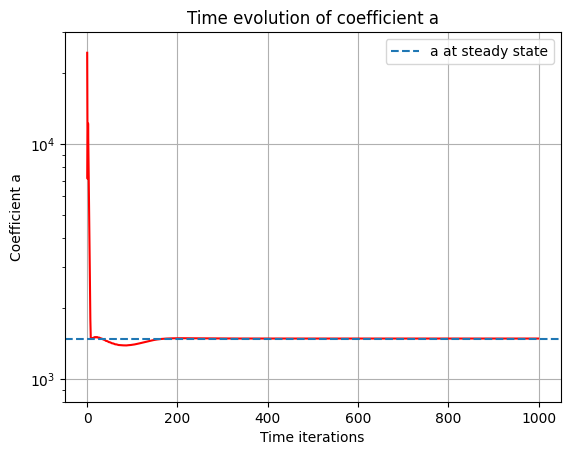

In [47]:
dv_dy = np.zeros((Nx,Nt))  # Initialization of dv/dy 
# Computation of dv/dy at each time step
for t in range(Nt):
    for j in range(Nx):
        if j == 0:  # bottom corner
            dv_dy[j, t] = abs((v[k(0, j+1), t] - v[k(0, j), t]) / dx)
        elif j == Nx - 1:  # top corner
            dv_dy[j, t] = abs((v[k(0, j), t] - v[k(0, j-1), t]) / dx)
        else:
            dv_dy[j, t] = abs((v[k(0, j+1), t] - v[k(0, j-1), t]) / (2*dx))

# Time evolution of a
dv_dy_max = np.zeros(Nt)
for n in range(Nt):
    dv_dy_max[n] = np.max(dv_dy[:, n])

# Plot of the coefficient as a function of time
plt.plot(dv_dy_max, "r")
plt.yscale("log")
plt.ylim(800, 30000)
plt.grid(True)
plt.xlabel("Time iterations")
plt.ylabel("Coefficient a")
plt.axhline(y=np.max(dv_dy[:, Nstat]), linestyle="--", label="a at steady state")
plt.title("Time evolution of coefficient a")
plt.legend(loc="upper right")

# Find the indices corresponding to the maximum dv/dy in space and time
indices_max = np.unravel_index(np.argmax(dv_dy), dv_dy.shape)
indices_max_stat = np.unravel_index(np.argmax(dv_dy[:, Nstat]), dv_dy[:, Nstat].shape)

print("The absolute maximum deformation coefficient is", round(np.max(dv_dy), 2), "s^-1 and is located on the left boundary at y =", indices_max[1] * dx, "m")
print("The deformation coefficient at steady state is", round(np.max(dv_dy[:, Nstat]), 2), "s^-1 and is located at y =", round(indices_max_stat[0] * dx, 4), "m")

The average values of deformation coefficients along a wall generally lie between $10^2$ and $10^5$ $s^{-1}$
, which suggests that our coefficient fits perfectly within this order of magnitude. It is higher near the upper and lower corners on the left simply because the velocity is greatest there, and it is purely in the y-direction. It is therefore logical for the coefficient to reach its maximum in these regions. We also observed that the velocities are almost zero halfway up the left wall, which further confirms that the velocity gradient is larger near the corners.

# Part 2: Transport of YN2

### Theory: The Transport Equation
Nitrogen is only present here to dilute the hot gases. In reality, methane combustion occurs solely with the oxygen contained in the air injection. We consider pure air composed of 79% $N_2$ and 21% $O_2$, and we neglect any impurities. The chemical reaction for methane combustion is written as:

\begin{equation}
CH_4 + 2O_2 \longrightarrow CO_2 + 2H_2 O
\end{equation}

Nitrogen is therefore a true spectator species in the reaction. It is not affected by temperature changes or depletion; it is only transported according to the following equation:

\begin{equation}
\frac{\partial Y_{N2}}{\partial t} + u\times \frac{\partial Y_{N2}}{\partial x} + v\times \frac{\partial Y_{N2}}{\partial y} = D \times (\frac{\partial^2 Y_{N2}}{\partial x^2} + \frac{\partial^2 Y_{N2}}{\partial y^2})
\end{equation}

With D = $\nu$  the mass diffusivity of the fluid. The aim of this part is therefore to solve this equation for $N_2$. To do so, we discretize the spatial derivatives in the same way as for the velocity, using centered discretizations.

In [53]:
# Initial conditions for N2
def YN2_0(Nx):
    Y0 = np.zeros((Nx*Nx))
    for i in range(Nx):      # x becomes the row index
        for j in range(Nx):  # y becomes the column index
            if j == 0:  # bottom boundary
                if 0 <= i < Nx//4:
                    Y0[k(i, j)] = 0.79
                if Nx//4 <= i < Nx//2:
                    Y0[k(i, j)] = 1
            if j == Nx-1:  # top boundary
                if Nx//4 <= i < Nx//2:
                    Y0[k(i, j)] = 1
    return Y0


In [54]:
# Calculation of YN2. YN2 is not affected by temperature because it is a spectator in the reaction

def calcul_YN2(u, v, YN2_0, dt, dx, D, Nt, Nx, rho):
    mu  = dt / (2*dx)
    mu2 = dt / dx**2

    YN2 = YN2_0(Nx).copy()
    YN2_f = np.zeros((Nx*Nx, 4))
    t = np.zeros(4)
    interval = [0, 30, 100, Nt-1]

    YN2_f[:, 0] = YN2.copy()
    t[0] = 0.0

    for n in range(1, Nt):
        Y_old = YN2.copy()  

        for i in range(1, Nx-1):
            for j in range(1, Nx-1):
                YN2[k(i,j)] = (Y_old[k(i,j)]- mu * ( u[k(i,j), n-1] * (Y_old[k(i+1,j)] - Y_old[k(i-1,j)]) + v[k(i,j), n-1] * (Y_old[k(i,j+1)] - Y_old[k(i,j-1)]))+ mu2 * D * (Y_old[k(i+1,j)] - 4*Y_old[k(i,j)] + Y_old[k(i-1,j)]+ Y_old[k(i,j+1)] + Y_old[k(i,j-1)]))

        # Boundary conditions
        for i in range(Nx):
            YN2[k(i,0)]    = YN2[k(i,1)]
            YN2[k(i,Nx-1)] = YN2[k(i,Nx-2)]
            if 0 <= i < Nx//4:
                YN2[k(i,0)] = 0.79
            elif Nx//4 <= i < Nx//2:
                YN2[k(i,0)]    = 1.0
                YN2[k(i,Nx-1)] = 1.0

        for j in range(Nx):
            YN2[k(0,j)]    = YN2[k(1,j)]
            YN2[k(Nx-1,j)] = YN2[k(Nx-2,j)]

        
        YN2 = np.clip(YN2, 0.0, 1.0)

        if n in interval:
            idx = interval.index(n)
            YN2_f[:, idx] = YN2
            t[idx] = n * dt

    return YN2_f, t


YN2_calc, time = calcul_YN2(u, v, YN2_0, dt, dx, D, Nt, Nx, rho)

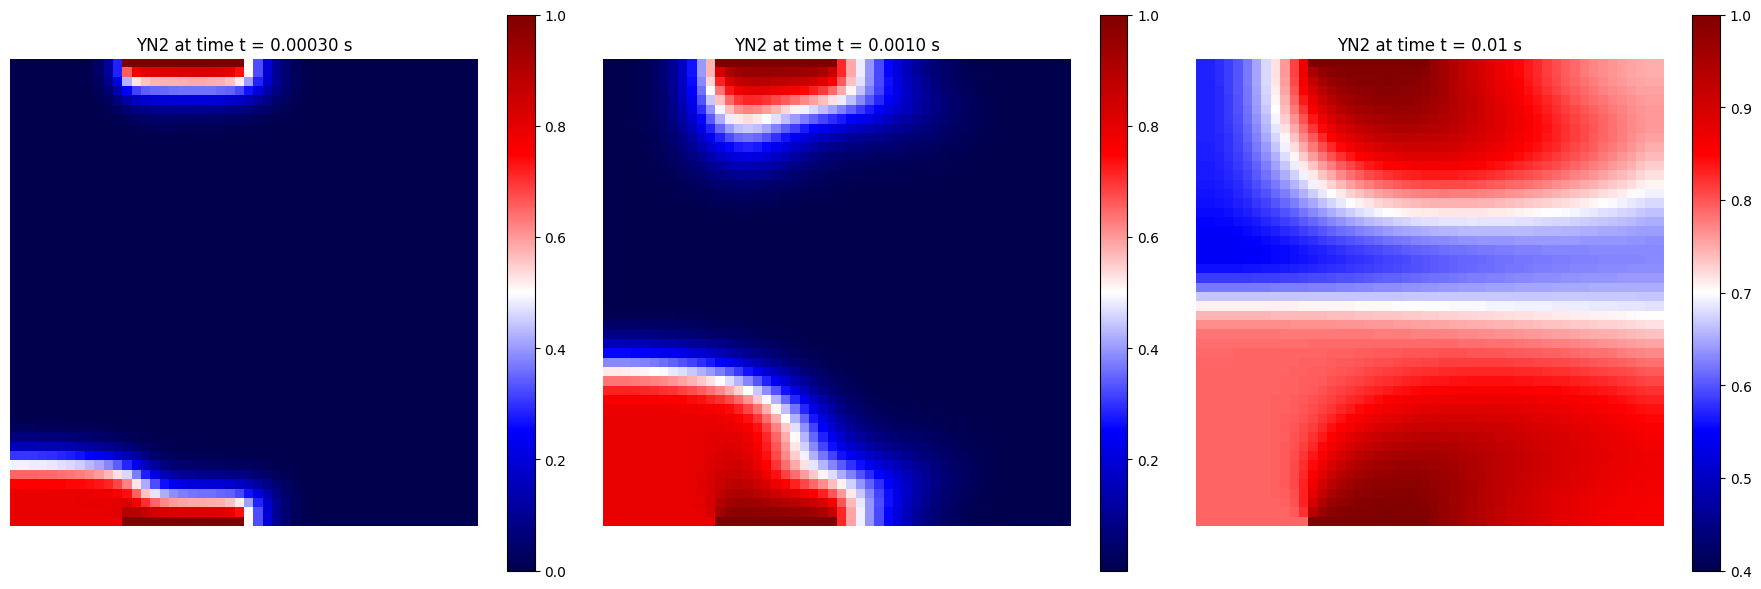

In [55]:
# Time evolution of YN2
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

im12 = axs2[0].imshow(np.reshape(YN2_calc,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs2[0].set_title(f"YN2 at time t = {time[1]:.5f} s")
axs2[0].invert_yaxis()
axs2[0].axis('off')  # Masquer les axes
fig2.colorbar(im12, ax=axs2[0])

im21 = axs2[1].imshow(np.reshape(YN2_calc,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs2[1].set_title(f"YN2 at time t = {time[2]:.4f} s")
axs2[1].invert_yaxis()
axs2[1].axis('off')  # Masquer les axes
fig2.colorbar(im21, ax=axs2[1])

im32 = axs2[2].imshow(np.reshape(YN2_calc,(Nx,Nx,4))[:,:,3], cmap='seismic', vmin=0.4, vmax=1)
axs2[2].set_title(f"YN2 at time t = {time[3]:} s")
axs2[2].invert_yaxis()
axs2[2].axis('off')  
fig2.colorbar(im32, ax=axs2[2])

plt.tight_layout()  
plt.show()


We clearly observe the asymmetric evolution of YN2 with respect to the horizontal midline of the box. This is explained by the fact that air is injected only from the bottom of the domain. The diffusion zone along the left boundary is also clearly visible. We extract the data along this wall and use the final time step so that we are certain to be in steady state, to plot the thickness of this diffusion zone.

In [56]:
# Lower and upper bounds
Bord_bas = round(0.1*0.79, 4)
Bord_haut = round(0.9*0.79, 4)

# Thickness on the left wall
thickness = np.reshape(YN2_calc, (Nx, Nx, 4)).copy()
thickness[(thickness < Bord_bas) | (thickness > Bord_haut)] = 0
thickness[(thickness > Bord_bas) & (thickness < Bord_haut)] = 1
left_thickness = thickness[:, 0, 3]
ep = np.sum(left_thickness) * dx


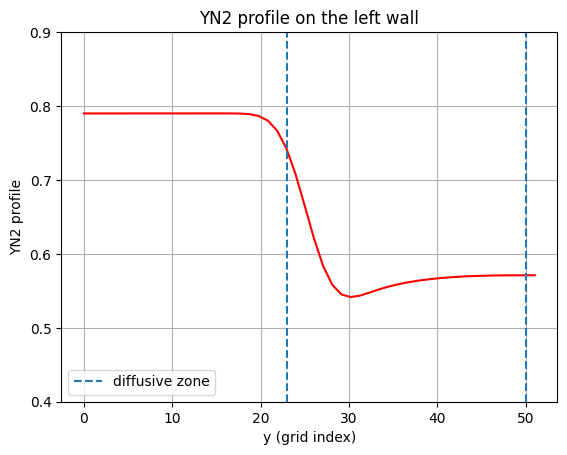

The thickness of the diffusive zone on the left boundary is 0.0011 m


In [57]:
YN2_mod = np.reshape(YN2_calc, (Nx, Nx, 4))
YN2_gauche = YN2_mod[:, 0, 3]
h = np.linspace(0, Nx+1, Nx)

# Plot of the YN2 profile on the left wall
plt.plot(h, YN2_gauche, 'r')  # I use the final time step to ensure steady state.
plt.grid(True)
plt.xlabel("y (grid index)")
plt.ylim(0.4, 0.9)
plt.axvline(x = Nx - ep/dx, linestyle="--", label="diffusive zone")
plt.axvline(x = Nx, linestyle="--")
plt.ylabel("YN2 profile")
plt.title("YN2 profile on the left wall")
plt.legend(loc="lower left")
plt.show()

print("The thickness of the diffusive zone on the left boundary is", round(ep, 4), "m")

The diffusive zone on the left boundary has the shape of a hyperbolic tangent under steady-state conditions. We can see that for values of y near 0, the concentration is 0.79, which corresponds to the injection value. In contrast, for y values near the top of the box, the concentration is much lower (around 0.5) and is influenced by the diffusion of the nitrogen injected at the top. We therefore observe that in the region where N2 is injected directly against the wall, there is essentially no diffusion, since all particles move to the right. Otherwise, we would expect to see an increase in concentration, which is not the case. Diffusion is much clearer in the upper part of the box, where the nitrogen particles that are not injected along the left boundary diffuse toward it. The decreasing zone we observe corresponds to the transition region between the upper diffusion zone and the lower injection zone. The thickness of the diffusive zone is: 0.0011 m.

# Part 3: Global Simulation of All Species and Temperature 

### Theory: The Transport Equations

The goal of this part is to simulate the transport and depletion of the four species involved in the combustion reaction: CH4, O2, H2O, and CO2. To do this, we aim to solve the following equation for each species:

\begin{equation}
\frac{\partial Y_{k}}{\partial t} + u\times \frac{\partial Y_{k}}{\partial x} + v\times \frac{\partial Y_{k}}{\partial y} = D \times (\frac{\partial^2 Y_{k}}{\partial x^2} + \frac{\partial^2 Y_{k}}{\partial y^2}) + \frac{\dot \omega_k}{\rho}
\end{equation} 

With $k$ the species considered, and $\dot{\omega}_k$ the reaction rate defined as $\dot{\omega}_k = W_k \nu_k Q$. Here, $W_k$ is the molar mass of each species, $\nu_k$ the molar stoichiometric coefficient, and $Q$ the reaction progress rate. $Q$ is defined by:


\begin{equation} 
Q = A[CH4][O2]^2e^{-Ta/T}
\end{equation}

With Ta the activation temperature set to $10000\,\text{K}$ and $A = 1.1 \times 10^8$. The transport equation for each species is coupled with the temperature transport equation, which gives us the following system to solve:


\begin{align}
& \frac{\partial Y_{k}}{\partial t} + u\times \frac{\partial Y_{k}}{\partial x} + v\times \frac{\partial Y_{k}}{\partial y} = D \times (\frac{\partial^2 Y_{k}}{\partial x^2} + \frac{\partial^2 Y_{k}}{\partial y^2}) + \frac{\dot \omega_k}{\rho}\\
&\frac{\partial T}{\partial t} + u\times \frac{\partial T}{\partial x} + v\times \frac{\partial T}{\partial y} = a \times (\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}) + \frac{\dot \omega_T}{\rho c_p}
\end{align}

With $\dot \omega_T$ the release of heat, which is expressed as: $\dot \omega_T = - \sum_k^Ns \frac{\Delta h_{f,k}^0}{W_k} \dot \omega_k$ avec $\Delta h_{f,k}^0$ the enthalpy of formation of each species k and D = a = $\nu$. 

We begin by defining the initial conditions for each species k (excluding N2). We assume that there is no H2O or CO2 at the start of the simulation, so their mole fractions are equal to 0 everywhere in the simulation box.

In [58]:
#Initial conditions for all species (excluding YN2)
def Yk_0(Nx, specie = "CH4"):
    Y0 = np.zeros((Nx*Nx))
    if specie == "CH4":
        for i in range(Nx):  # x become the line index
            if  0 <= i < Nx//4:
                Y0[k(i,Nx-1)] = 1
        return Y0
    elif specie == "O2":
        for i in range(Nx):  
            if  0 <= i < Nx//4:
                Y0[k(i,0)] = 0.21
        return Y0
    else:
        return Y0

To gain a better understanding of the pure transport of each species, I implemented a solver to visualize the transport of CH4 and O2 without considering temperature.

In [59]:
#Transport of Y without T or depletion (to get an idea of diffusion and advection on particles)
def Yk_calc_wo_T(u,v, Yk_0, dt, dx, D, Nt, Nx, rho, specie = "N2"):
    Yk_f = np.zeros((Nx**2,4))
    t = np.zeros(4)
    mu = dt/(2*dx)
    mu2 = dt/dx**2
    intervals = [0,(Nt-1)//10, (Nt-1)//4, (Nt-1)]
    if specie == "CH4":
        Yk = Yk_0.copy()
        Yk_f[:,0] = Yk_0.copy()
        t[0] = 0
        for n in range(1,Nt):
            for i in range(1, Nx-1):
                for j in range(1, Nx-1):
                    Yk[k(i,j)] = Yk[k(i,j)] - mu * (u[k(i,j),n-1] * (Yk[k(i+1,j)] - Yk[k(i-1,j)]) + v[k(i,j),n-1] * (Yk[k(i,j+1)] -Yk[k(i,j-1)])) + mu2 * D * ( Yk[k(i+1,j)] - 4*Yk[k(i,j)] + Yk[k(i-1,j)] + Yk[k(i,j+1)]  + Yk[k(i,j-1)])
                    +mu2 *(u[k(i,j),n-1]**2) * ( Yk[k(i+1,j)] - 2*Yk[k(i,j)] +Yk[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(Yk[k(i,j+1)] + Yk[k(i,j-1)] - 2*Yk[k(i,j)] )
            for i in range(Nx):
                Yk[k(i,0)] = Yk[k(i,1)]
                Yk[k(i,Nx-1)] = Yk[k(i,Nx-2)]
                if  0 <= i < Nx//4:
                    Yk[k(i,Nx-1)] = 1
            for j in range(Nx):
                Yk[k(0,j)] = Yk[k(1,j)]  
                Yk[k(Nx-1,j)] = Yk[k(Nx-2,j)]  
            if n in intervals:
                index = intervals.index(n)
                Yk_f[:,index] = Yk
                t[index] = n*dt
        return Yk_f, t
    elif specie == "O2":
        Yk = Yk_0.copy()
        Yk_f[:,0] = Yk_0.copy()
        t[0] = 0
        for n in range(1,Nt):
            for i in range(1, Nx-1):
                for j in range(1, Nx-1):
                    Yk[k(i,j)] = Yk[k(i,j)] - mu * (u[k(i,j),n-1] * (Yk[k(i+1,j)] - Yk[k(i-1,j)]) + v[k(i,j),n-1] * (Yk[k(i,j+1)] -Yk[k(i,j-1)])) +  mu2 * D * (Yk[k(i+1,j)] - 4*Yk[k(i,j)] + Yk[k(i-1,j)] + Yk[k(i,j+1)]  + Yk[k(i,j-1)])
                    ++mu2 *(u[k(i,j),n-1]**2) * ( Yk[k(i+1,j)] - 2*Yk[k(i,j)] +Yk[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(Yk[k(i,j+1)] + Yk[k(i,j-1)] - 2*Yk[k(i,j)] )
            for i in range(Nx):
                Yk[k(i,0)] = Yk[k(i,1)]
                Yk[k(i,Nx-1)] = Yk[k(i,Nx-2)]
                if 0 <= i < Nx//4:
                    Yk[k(i,0)] = 0.21
            for j in range(Nx):
                Yk[k(0,j)] = Yk[k(1,j)]  
                Yk[k(Nx-1,j)] = Yk[k(Nx-2,j)]  
            if n in intervals:
                index = intervals.index(n)
                Yk_f[:,index] = Yk
                t[index] = n*dt
        return Yk_f, t

YCH4_cal,time = Yk_calc_wo_T(u,v, Yk_0(Nx, specie = "CH4"), dt, dx, D, Nt, Nx, rho, specie = "CH4")
YO2_cal,time = Yk_calc_wo_T(u,v, Yk_0(Nx, specie = "O2"), dt, dx, D, Nt, Nx, rho, specie = "O2")

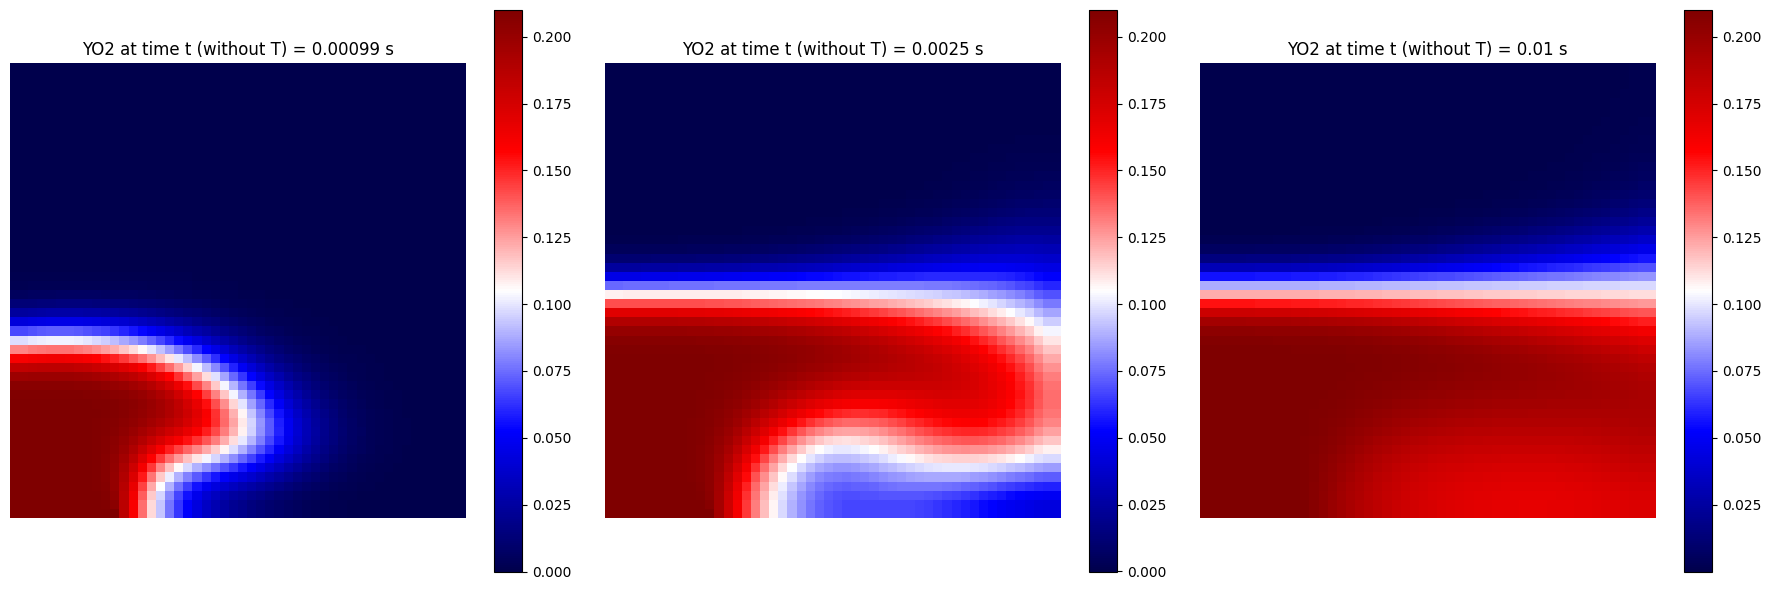

In [60]:
#O2 evolution without taking temperature into account and without combustion
fig3, axs3 = plt.subplots(1, 3, figsize=(18, 6)) 

im13 = axs3[0].imshow(np.reshape(YO2_cal,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs3[0].set_title(f"YO2 at time t (without T) = {time[1]:.5f} s")
axs3[0].invert_yaxis()
axs3[0].axis('off')  
fig3.colorbar(im13, ax=axs3[0])

im23 = axs3[1].imshow(np.reshape(YO2_cal,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs3[1].set_title(f"YO2 at time t (without T) = {time[2]:.4f} s")
axs3[1].invert_yaxis()
axs3[1].axis('off')  
fig3.colorbar(im23, ax=axs3[1])

im33 = axs3[2].imshow(np.reshape(YO2_cal,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs3[2].set_title(f"YO2 at time t (without T) = {time[3]:.2f} s")
axs3[2].invert_yaxis()
axs3[2].axis('off')  
fig3.colorbar(im33, ax=axs3[2])

plt.tight_layout() 
plt.show()

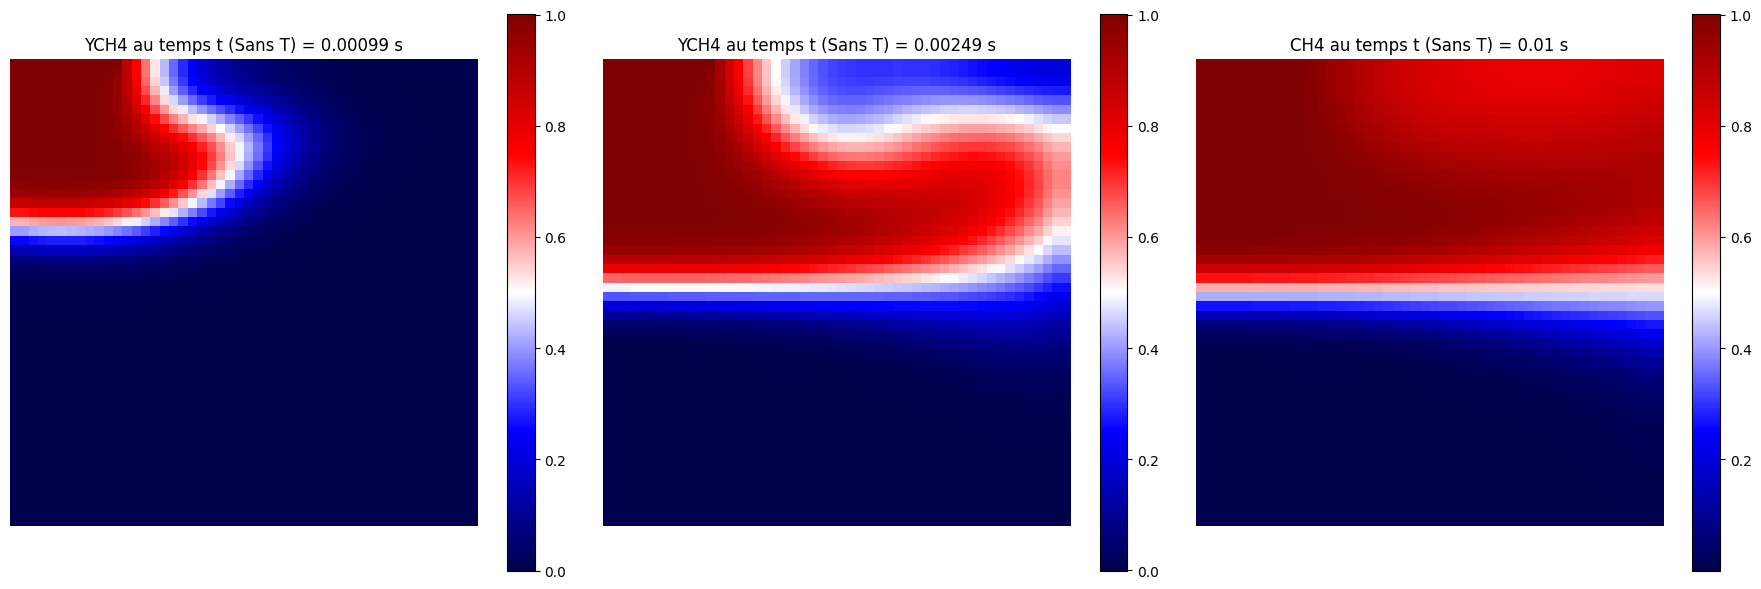

In [61]:
#Evolution of CH4 without taking temperature into account and without combustion
fig3, axs3 = plt.subplots(1, 3, figsize=(18, 6)) 

im13 = axs3[0].imshow(np.reshape(YCH4_cal,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs3[0].set_title(f"YCH4 au temps t (Sans T) = {time[1]:.5f} s")
axs3[0].invert_yaxis()
axs3[0].axis('off')  
fig3.colorbar(im13, ax=axs3[0])

im23 = axs3[1].imshow(np.reshape(YCH4_cal,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs3[1].set_title(f"YCH4 au temps t (Sans T) = {time[2]:.5f} s")
axs3[1].invert_yaxis()
axs3[1].axis('off')  
fig3.colorbar(im23, ax=axs3[1])

im33 = axs3[2].imshow(np.reshape(YCH4_cal,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs3[2].set_title(f"CH4 au temps t (Sans T) = {time[3]:.2f} s")
axs3[2].invert_yaxis()
axs3[2].axis('off')  
fig3.colorbar(im33, ax=axs3[2])

plt.tight_layout() 
plt.show()

Without considering the impact of temperature, and therefore without taking depletion into account, we observe that the transport of CH4 and O2 is symmetrical. This is expected since we are solving the same equation, simply for different initial conditions. This is reflected in the mole fractions, as that of CH4 reaches 1 while that of O2 is capped at 0.2.

We now proceed to solve the entire system, but we do not consider temperature transport for the moment. The temperature is fixed at 300 K everywhere in the box except for a centered horizontal band of 0.5 mm where the temperature is constant at 1000 K (to allow combustion). We therefore initially consider a homogeneous reactor.

In [62]:
#Definition of temperature T at t=0 across the entire grid
def T_0(Nx):
    T0 = np.zeros((Nx*Nx))
    for i in range(Nx):
        for j in range(Nx):
            if 0.00075 <= j*dx < 0.00125:
                T0[k(i,j)] = 1000
            else:
                T0[k(i,j)] = 300
    return T0

To determine the appropriate $\Delta t_{chem}$ for our calculation, I look at the order of magnitude of $\dot \omega_k$, choosing the one most likely to be large, and decide that $\Delta t_{chem}$ will have an order of magnitude inverse to the largest $\dot \omega_k$ to ensure no discrepancies. To calculate the possible $Q_{max}$, I take the maximum concentrations of CH4 and O2 in the middle band (where the species meet) and substitute them into the definition of the molar concentrations [CH4] and [O2], defined as $[k] = \rho \frac{Y_k}{W_k}$. I choose an arbitrary maximum temperature $T_{max}$ based on temperatures typically reached during combustion (here, for the homogeneous reactor, I choose slightly above 1000 K to ensure a sufficiently small $\Delta t_{chem}$).

In [64]:
#Calculation for homogeneous reactor
def homogeneous_reactor(u,v, Nx, Tf, Nt, Nstat, dt, cp, rho, D, Tmax):
    #Définition des constantes 
    Ta = 10000
    A = 1.1e8
    
    #Molar masses
    WCH4 = 16.04e-3
    WO2 = 31.99e-3
    WH2O = 18.01e-3
    WCO2 = 44.00e-3

    #Stoichiometric coefficients
    nu_CH4 = -1
    nu_O2 = -2
    nu_H2O = 2
    nu_CO2 = 1

    #enlthalpie
    HO2 = 0
    HCH4 = -74.9e3
    HH2O = -241.818e3
    HCO2 = -393.52e3

    #Determination of dtchem
    Qmax = A*(rho*0.5/WCH4)*((rho*0.1/WO2)**2)*np.exp(-10000/Tmax)
    dtchem_f = 1e3/(Qmax*44)
    if dtchem_f < dt:
        dtchem = dtchem_f
        Ntchem = int(Tf/dtchem - 1)
        print("Ntchem =", Ntchem)

    else:
        Ntchem = Nt
        dtchem = dt
        print("Ntchem =", Ntchem)
        
    ratio = int((dt // dtchem) + 1)
    dtchem = dt/(ratio) #to have a dtchem exactly multiple of dt
    thydro = np.linspace(0,Tf,Nt)
    tchem = np.linspace(0,Tf,Ntchem)
    print("dthydro = ",dt)
    print("Nthydro=", Nt)
    print("ratio =", ratio)
    print("dtchem =", dtchem)
    interval = [0,(Nt-1)//4, Nstat + 4, Nt-1] #the time values I want to save for my plots
    mu = dtchem/(2*dx)
    mu2 = dtchem/dx**2
    
    #Definition of empty arrays
    YCH4_f = np.zeros((Nx*Nx,4))
    YO2_f = np.zeros((Nx*Nx,4))
    YH2O_f = np.zeros((Nx*Nx,4))
    YCO2_f = np.zeros((Nx*Nx,4))
    T_t_f = np.zeros((Nx*Nx,4))
    t = np.zeros(4)

    #Definition of initial conditions
    YCH40 = Yk_0(Nx, specie = "CH4")
    YO20 = Yk_0(Nx, specie = "O2")
    YH2O0 = Yk_0(Nx, specie = "H2O")
    YCO20 = Yk_0(Nx, specie = "CO2")
    T0 = T_0(Nx)
        
    #Initials condtions 
    YCH4 = YCH40.copy()
    YO2 = YO20.copy()
    YH2O = YH2O0.copy()
    YCO2 = YCO20.copy()
    T_t = T0.copy()
    YCH4_f[:,0] = YCH40.copy()
    YO2_f[:,0] = YO20.copy()
    YH2O_f[:,0] = YH2O0.copy()
    YCO2_f[:,0] = YCO20.copy()
    t[0] = 0
    
    for n in range(1,Nt):
        for ni in range(ratio):
            for i in range(1,Nx-1):
                for j in range(1,Nx-1):        
                    #Calculation of Q
                    Q = A* (rho* (YCH4[k(i,j)]/WCH4) * (rho* (YO2[k(i,j)]/WO2)**2) ) * np.exp(-Ta/T_t[k(i,j)])
                    #Calculations of wk
                    wCH4 = WCH4*nu_CH4*Q
                    wO2 = WO2*nu_O2*Q
                    wCO2 = WCO2*nu_CO2*Q
                    wH2O = WH2O*nu_H2O*Q
                    
                    #Calculation of species transport
                    YCH4[k(i,j)] = YCH4[k(i,j)] - mu * (u[k(i,j),n-1] * (YCH4[k(i+1,j)] - YCH4[k(i-1,j)]) + v[k(i,j),n-1] * (YCH4[k(i,j+1)] -YCH4[k(i,j-1)])) + mu2 * D * (YCH4[k(i+1,j)] - 4*YCH4[k(i,j)] + YCH4[k(i-1,j)] + YCH4[k(i,j+1)]  + YCH4[k(i,j-1)]) + dtchem*(1/rho)*wCH4
                    +mu2 *(u[k(i,j),n-1]**2) * ( YCH4[k(i+1,j)] - 2*YCH4[k(i,j)] +YCH4[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCH4[k(i,j+1)] + YCH4[k(i,j-1)] - 2*YCH4[k(i,j)] )
                    
                    YO2[k(i,j)]  = YO2[k(i,j)]  - mu * (u[k(i,j),n-1] * (YO2[k(i+1,j)] - YO2[k(i-1,j)]) + v[k(i,j),n-1] * (YO2[k(i,j+1)] -YO2[k(i,j-1)])) + mu2 * D * (YO2[k(i+1,j)] - 4*YO2[k(i,j)] + YO2[k(i-1,j)] + YO2[k(i,j+1)]  + YO2[k(i,j-1)]) + dtchem*(1/rho)*wO2
                    +mu2 *(u[k(i,j),n-1]**2) * ( YO2[k(i+1,j)] - 2*YO2[k(i,j)] +YO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YO2[k(i,j+1)] + YO2[k(i,j-1)] - 2*YO2[k(i,j)] )
                    
                    YH2O[k(i,j)] = YH2O[k(i,j)] - mu * (u[k(i,j),n-1] * (YH2O[k(i+1,j)] - YH2O[k(i-1,j)]) + v[k(i,j),n-1] * (YH2O[k(i,j+1)] -YH2O[k(i,j-1)])) + mu2 * D * (YH2O[k(i+1,j)] - 4*YH2O[k(i,j)] + YH2O[k(i-1,j)] + YH2O[k(i,j+1)]  + YH2O[k(i,j-1)]) + dtchem*(1/rho)*wH2O
                    +mu2 *(u[k(i,j),n-1]**2) * ( YH2O[k(i+1,j)] - 2*YH2O[k(i,j)] +YH2O[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YH2O[k(i,j+1)] + YH2O[k(i,j-1)] - 2*YH2O[k(i,j)] )
                    
                    YCO2[k(i,j)] = YCO2[k(i,j)] - mu * (u[k(i,j),n-1] * (YCO2[k(i+1,j)] - YCO2[k(i-1,j)]) + v[k(i,j),n-1] * (YCO2[k(i,j+1)] -YCO2[k(i,j-1)])) + mu2 * D * (YCO2[k(i+1,j)] - 4*YCO2[k(i,j)] + YCO2[k(i-1,j)] + YCO2[k(i,j+1)]  + YCO2[k(i,j-1)]) + dtchem*(1/rho)*wCO2
                    +mu2 *(u[k(i,j),n-1]**2) * ( YCO2[k(i+1,j)] - 2*YCO2[k(i,j)] +YCO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCO2[k(i,j+1)] + YCO2[k(i,j-1)] - 2*YCO2[k(i,j)] )
                    
                    T_t[k(i,j)] = T_t[k(i,j)]

        
        #Boundary conditions
            for i in range(Nx):
                for j in range(Nx):
                    if i == 0: #left wall
                        YCH4[k(i,j)] = YCH4[k(i+1,j)]
                        YO2[k(i,j)] = YO2[k(i+1,j)]
                        YH2O[k(i,j)] = YH2O[k(i+1,j)]
                        YCO2[k(i,j)] = YCO2[k(i+1,j)]
                        T_t[k(i,j)] = T_t[k(i+1,j)]
                    elif i == Nx-1: #right wall
                        YCH4[k(i,j)] = YCH4[k(i-1,j)]
                        YO2[k(i,j)] = YO2[k(i-1,j)]
                        YH2O[k(i,j)] = YH2O[k(i-1,j)]
                        YCO2[k(i,j)] = YCO2[k(i-1,j)]
                        T_t[k(i,j)] = T_t[k(i-1,j)]
                    elif j == 0: #bottom wall
                        YCH4[k(i,j)] = YCH4[k(i,j+1)]
                        YO2[k(i,j)] = YO2[k(i,j+1)]
                        YH2O[k(i,j)] = YH2O[k(i,j+1)]
                        YCO2[k(i,j)] = YCO2[k(i,j+1)]
                        T_t[k(i,j)] = T_t[k(i,j+1)]
                        if  0 <= i < Nx//4:
                            YO2[k(i,j)] = 0.21
                    elif j == Nx-1: #upper wall
                        YCH4[k(i,j)] = YCH4[k(i,j-1)]
                        YO2[k(i,j)] = YO2[k(i,j-1)]
                        YH2O[k(i,j)] = YH2O[k(i,j-1)]
                        YCO2[k(i,j)] = YCO2[k(i,j-1)]
                        T_t[k(i,j)] = T_t[k(i,j-1)]
                        if  0 <= i < Nx//4:
                            YCH4[k(i,j)] = 1
                    if n in interval:
                        index = interval.index(n)
                        YCH4_f[k(i,j),index] = YCH4[k(i,j)]
                        YO2_f[k(i,j),index] = YO2[k(i,j)]
                        YH2O_f[k(i,j),index] = YH2O[k(i,j)]
                        YCO2_f[k(i,j),index] = YCO2[k(i,j)]
                        t[index] = n*dt
                        T_t_f[k(i,j),index] = T_t[k(i,j)]

    return YCH4_f, YO2_f, YH2O_f, YCO2_f, T_t_f, Ntchem, t

YCH4, YO2, YH2O, YCO2, Temp, Ntchem, time = homogeneous_reactor(u,v, Nx, Tf, Nt, Nstat, dt, cp, rho, D, 1000)

Ntchem = 1047
dthydro =  1.001001001001001e-05
Nthydro= 1000
ratio = 2
dtchem = 5.005005005005005e-06


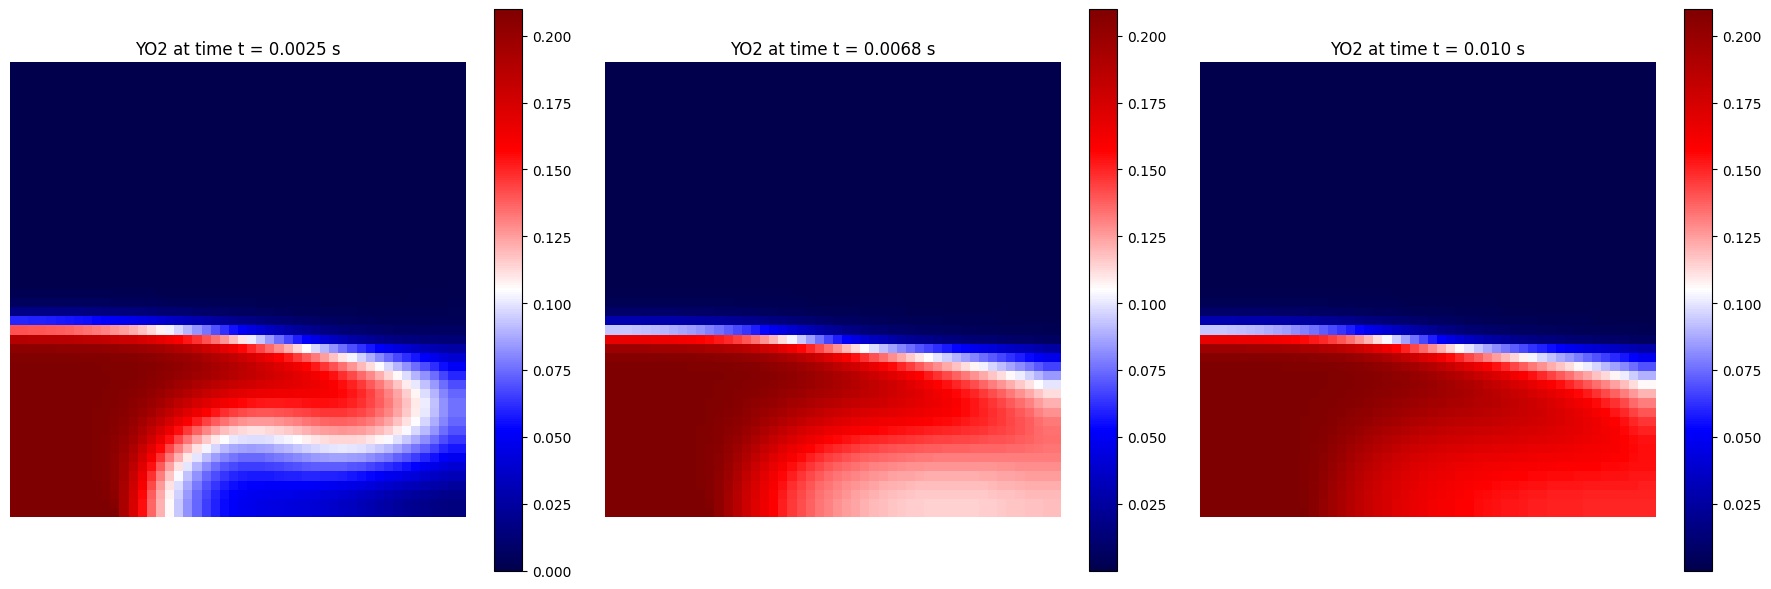

In [65]:
#O2 evolution taking into account temperature and with combustion = Homogeneous temperature at 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6)) 

im14 = axs4[0].imshow(np.reshape(YO2,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YO2 at time t = {time[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YO2,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YO2 at time t = {time[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YO2,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YO2 at time t = {time[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

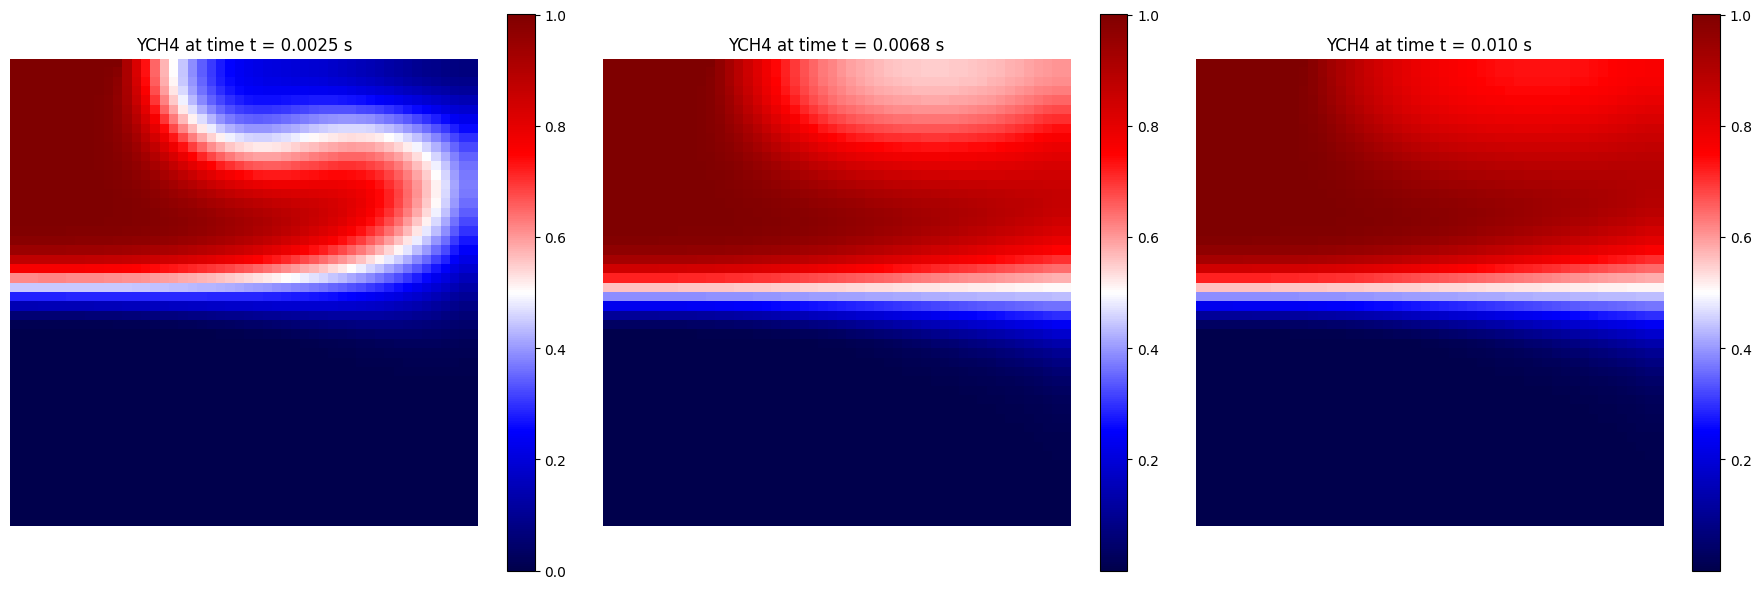

In [66]:
#CH4 evolution taking into account temperature and with combustion = Homogeneous temperature at 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  

im14 = axs4[0].imshow(np.reshape(YCH4,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCH4 at time t = {time[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YCH4,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCH4 at time t = {time[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YCH4,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCH4 at time t = {time[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

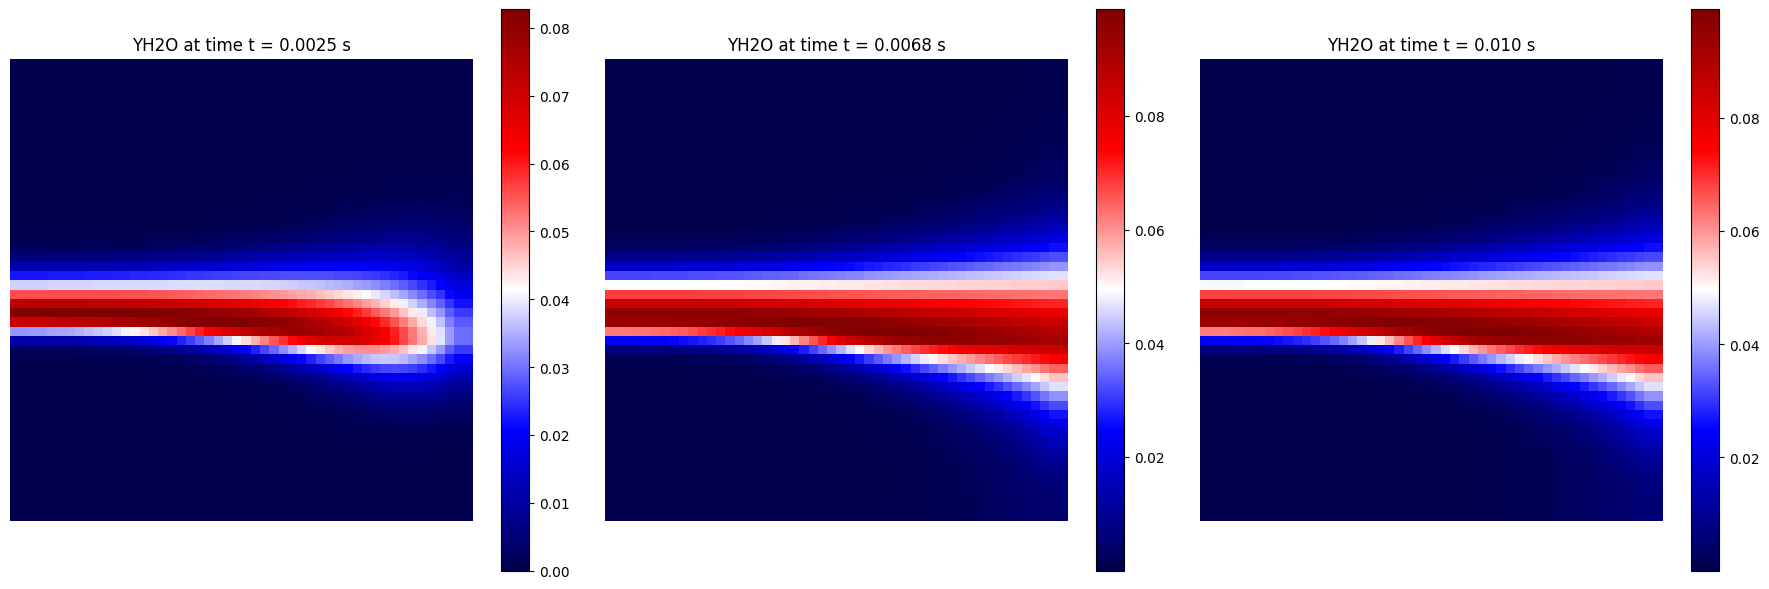

In [67]:
#H20 evolution taking into account temperature and with combustion = Homogeneous temperature at 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YH2O,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YH2O at time t = {time[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YH2O,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YH2O at time t = {time[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YH2O,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YH2O at time t = {time[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

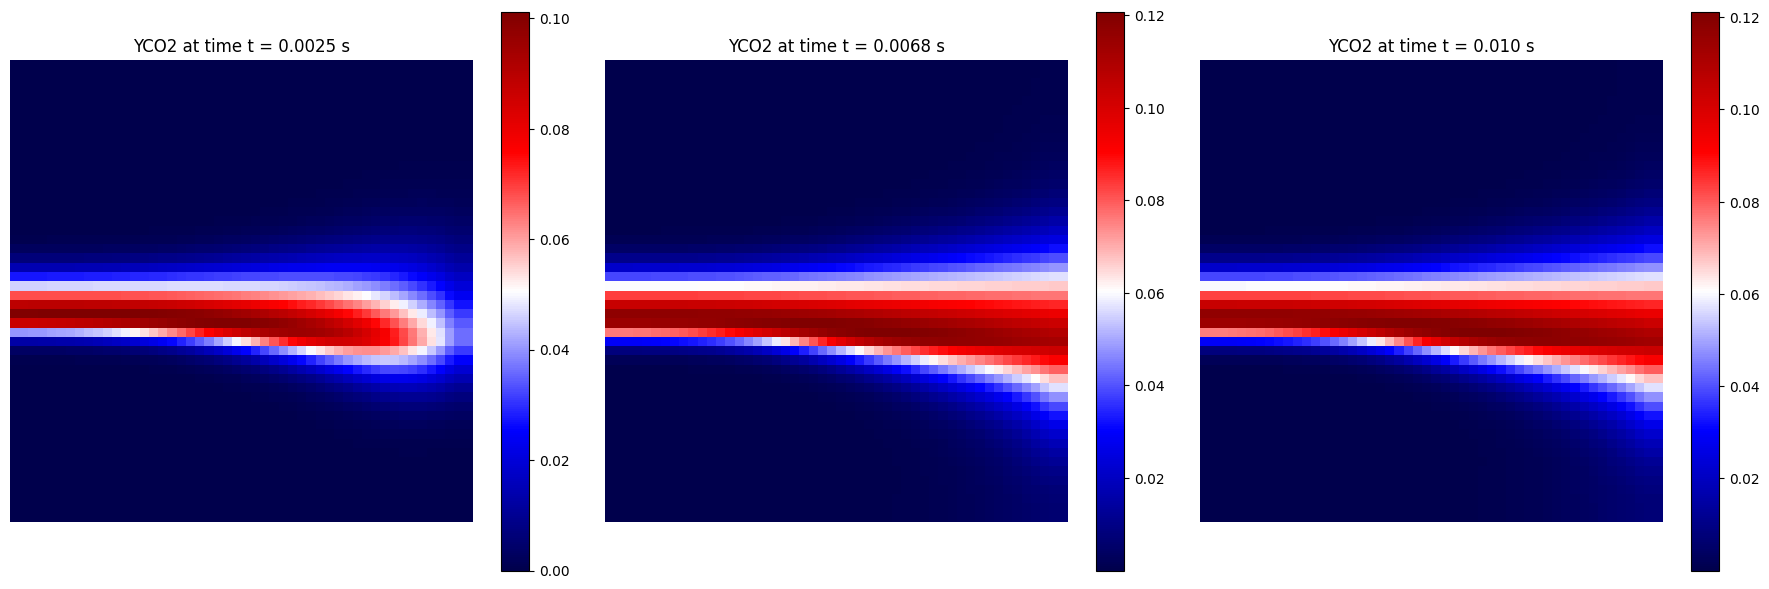

In [68]:
#CO2 evolution taking into account temperature and with combustion = Homogeneous temperature at 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YCO2,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCO2 at time t = {time[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YCO2,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCO2 at time t = {time[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YCO2,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCO2 at time t = {time[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

With a consistent temperature throughout the reaction, we observe the production of H2O and CO2, which stabilizes over time. For the transport of CH4 and O2, taking temperature into account, their evolution over time is no longer symmetrical. The reaction occurs, and H2O and CO2 are produced, in areas where there is no CH4 or O2. We assume that the flame is stable when the steady-state time is reached, which allows us to move to the reactor code with temperature transport. For this, as long as the code runs for a time shorter than the steady-state time, the temperature remains consistent, as in the first case. However, when this time is exceeded, we activate temperature transport while continuing to solve the species transport equations. This leads us to the following code.

In [70]:
def reactor(u,v, Nx, Tf, Nt, dt, cp, rho, D, a, Tmax, Nstat):
    #Definition of constants 
    Ta = 10000
    A = 1.1e8
    
    WCH4 = 16.04e-3
    WO2 = 31.99e-3
    WH2O = 18.01e-3
    WCO2 = 44.00e-3

    nu_CH4 = -1
    nu_O2 = -2
    nu_H2O = 2
    nu_CO2 = 1

    HO2 = 0
    HCH4 = -74.9e3
    HH2O = -241.818e3
    HCO2 = -393.52e3

    Qmax = A*(rho*0.5/WCH4)*((rho*0.1/WO2)**2)*np.exp(-10000/Tmax)
    dtchem_f = 1e3/(Qmax*10)

    if dtchem_f < dt:
        dtchem = dtchem_f
        Ntchem = int(Tf/dtchem - 1)
        print("Ntchem =", Ntchem)

    else:
        Ntchem = Nt
        dtchem = dt
        print("Ntchem =", Ntchem)
        
    ratio = int((dt // dtchem) + 1)
    dtchem = dt/(ratio)
    thydro = np.linspace(0,Tf,Nt)
    tchem = np.linspace(0,Tf,Ntchem)
    print("dthydro = ",dt)
    print("Nthydro=", Nt)
    print("ratio =", ratio)
    print("dtchem =", dtchem)
    interval = [0,(Nt-1)//4, Nstat + 4, Nt-1]
    mu = dtchem/(2*dx)
    mu2 = dtchem/dx**2
    
    YCH4_f = np.zeros((Nx*Nx,4))
    YO2_f = np.zeros((Nx*Nx,4))
    YH2O_f = np.zeros((Nx*Nx,4))
    YCO2_f = np.zeros((Nx*Nx,4))
    T_t_f = np.zeros((Nx*Nx,4))
    t = np.zeros(4)

    YCH40 = Yk_0(Nx, specie = "CH4")
    YO20 = Yk_0(Nx, specie = "O2")
    YH2O0 = Yk_0(Nx, specie = "H2O")
    YCO20 = Yk_0(Nx, specie = "CO2")
    T0 = T_0(Nx)
        
    YCH4 = YCH40.copy()
    YO2 = YO20.copy()
    YH2O = YH2O0.copy()
    YCO2 = YCO20.copy()
    T_t = T0.copy()
    YCH4_f[:,0] = YCH40.copy()
    YO2_f[:,0] = YO20.copy()
    YH2O_f[:,0] = YH2O0.copy()
    YCO2_f[:,0] = YCO20.copy()
    T_t_f[:,0] = T0.copy()
    t[0] = 0
    
    Temp_max = np.zeros((Nt))
    
    Temp_max[0] = 0
    Temperature_max = 1000
    for n in range(1,Nt):
        if n < Nstat:
            for ni in range(ratio):
                for i in range(1,Nx-1):
                    for j in range(1,Nx-1):
                        Q = A* (rho* (YCH4[k(i,j)]/WCH4) * (rho* (YO2[k(i,j)]/WO2)**2) ) * np.exp(-Ta/T_t[k(i,j)])
                        wCH4 = WCH4*nu_CH4*Q
                        wO2 = WO2*nu_O2*Q
                        wCO2 = WCO2*nu_CO2*Q
                        wH2O = WH2O*nu_H2O*Q
                
                        YCH4[k(i,j)] = YCH4[k(i,j)] - mu * (u[k(i,j),n-1] * (YCH4[k(i+1,j)] - YCH4[k(i-1,j)]) + v[k(i,j),n-1] * (YCH4[k(i,j+1)] -YCH4[k(i,j-1)])) + mu2 * D * (YCH4[k(i+1,j)] - 4*YCH4[k(i,j)] + YCH4[k(i-1,j)] + YCH4[k(i,j+1)]  + YCH4[k(i,j-1)]) + dtchem*(1/rho)*wCH4
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCH4[k(i+1,j)] - 2*YCH4[k(i,j)] +YCH4[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCH4[k(i,j+1)] + YCH4[k(i,j-1)] - 2*YCH4[k(i,j)] )
                    
                        YO2[k(i,j)]  = YO2[k(i,j)]  - mu * (u[k(i,j),n-1] * (YO2[k(i+1,j)] - YO2[k(i-1,j)]) + v[k(i,j),n-1] * (YO2[k(i,j+1)] -YO2[k(i,j-1)])) + mu2 * D * (YO2[k(i+1,j)] - 4*YO2[k(i,j)] + YO2[k(i-1,j)] + YO2[k(i,j+1)]  + YO2[k(i,j-1)]) + dtchem*(1/rho)*wO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YO2[k(i+1,j)] - 2*YO2[k(i,j)] +YO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YO2[k(i,j+1)] + YO2[k(i,j-1)] - 2*YO2[k(i,j)] )
                    
                        YH2O[k(i,j)] = YH2O[k(i,j)] - mu * (u[k(i,j),n-1] * (YH2O[k(i+1,j)] - YH2O[k(i-1,j)]) + v[k(i,j),n-1] * (YH2O[k(i,j+1)] -YH2O[k(i,j-1)])) + mu2 * D * (YH2O[k(i+1,j)] - 4*YH2O[k(i,j)] + YH2O[k(i-1,j)] + YH2O[k(i,j+1)]  + YH2O[k(i,j-1)]) + dtchem*(1/rho)*wH2O
                        +mu2 *(u[k(i,j),n-1]**2) * ( YH2O[k(i+1,j)] - 2*YH2O[k(i,j)] +YH2O[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YH2O[k(i,j+1)] + YH2O[k(i,j-1)] - 2*YH2O[k(i,j)] )
                    
                        YCO2[k(i,j)] = YCO2[k(i,j)] - mu * (u[k(i,j),n-1] * (YCO2[k(i+1,j)] - YCO2[k(i-1,j)]) + v[k(i,j),n-1] * (YCO2[k(i,j+1)] -YCO2[k(i,j-1)])) + mu2 * D * (YCO2[k(i+1,j)] - 4*YCO2[k(i,j)] + YCO2[k(i-1,j)] + YCO2[k(i,j+1)]  + YCO2[k(i,j-1)]) + dtchem*(1/rho)*wCO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCO2[k(i+1,j)] - 2*YCO2[k(i,j)] +YCO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCO2[k(i,j+1)] + YCO2[k(i,j-1)] - 2*YCO2[k(i,j)] )
                    
                        T_t[k(i,j)] = T_t[k(i,j)] 
                for i in range(Nx):
                    for j in range(Nx):
                        if i == 0: 
                            YCH4[k(i,j)] = YCH4[k(i+1,j)]
                            YO2[k(i,j)] = YO2[k(i+1,j)]
                            YH2O[k(i,j)] = YH2O[k(i+1,j)]
                            YCO2[k(i,j)] = YCO2[k(i+1,j)]
                            T_t[k(i,j)] = T_t[k(i+1,j)]
                        elif i == Nx-1: 
                            YCH4[k(i,j)] = YCH4[k(i-1,j)]
                            YO2[k(i,j)] = YO2[k(i-1,j)]
                            YH2O[k(i,j)] = YH2O[k(i-1,j)]
                            YCO2[k(i,j)] = YCO2[k(i-1,j)]
                            T_t[k(i,j)] = T_t[k(i-1,j)]
                        elif j == 0: 
                            YCH4[k(i,j)] = YCH4[k(i,j+1)]
                            YO2[k(i,j)] = YO2[k(i,j+1)]
                            YH2O[k(i,j)] = YH2O[k(i,j+1)]
                            YCO2[k(i,j)] = YCO2[k(i,j+1)]
                            T_t[k(i,j)] = T_t[k(i,j+1)]
                            if  0 <= i < Nx//4:
                                YO2[k(i,j)] = 0.21
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
                        elif j == Nx-1: 
                            YCH4[k(i,j)] = YCH4[k(i,j-1)]
                            YO2[k(i,j)] = YO2[k(i,j-1)]
                            YH2O[k(i,j)] = YH2O[k(i,j-1)]
                            YCO2[k(i,j)] = YCO2[k(i,j-1)]
                            T_t[k(i,j)] = T_t[k(i,j-1)]
                            if  0 <= i < Nx//4:
                                YCH4[k(i,j)] = 1
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
        else:
            for ni in range(ratio):
                for i in range(1,Nx-1):
                    for j in range(1,Nx-1):
                        Q = A* (rho* (YCH4[k(i,j)]/WCH4) * (rho* (YO2[k(i,j)]/WO2)**2) ) * np.exp(-Ta/T_t[k(i,j)])
                        wCH4 = WCH4*nu_CH4*Q
                        wO2 = WO2*nu_O2*Q
                        wCO2 = WCO2*nu_CO2*Q
                        wH2O = WH2O*nu_H2O*Q
                        wT = - ((HCH4/WCH4)*wCH4 + (HO2/WO2)*wO2 + (HH2O/WH2O)*wH2O + (HCO2/WCO2)*wCO2)
                        
                        YCH4[k(i,j)] = YCH4[k(i,j)] - mu * (u[k(i,j),n-1] * (YCH4[k(i+1,j)] - YCH4[k(i-1,j)]) + v[k(i,j),n-1] * (YCH4[k(i,j+1)] -YCH4[k(i,j-1)])) + mu2 * D * (YCH4[k(i+1,j)] - 4*YCH4[k(i,j)] + YCH4[k(i-1,j)] + YCH4[k(i,j+1)]  + YCH4[k(i,j-1)]) + dtchem*(1/rho)*wCH4
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCH4[k(i+1,j)] - 2*YCH4[k(i,j)] +YCH4[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCH4[k(i,j+1)] + YCH4[k(i,j-1)] - 2*YCH4[k(i,j)] )
                    
                        YO2[k(i,j)]  = YO2[k(i,j)]  - mu * (u[k(i,j),n-1] * (YO2[k(i+1,j)] - YO2[k(i-1,j)]) + v[k(i,j),n-1] * (YO2[k(i,j+1)] -YO2[k(i,j-1)])) + mu2 * D * (YO2[k(i+1,j)] - 4*YO2[k(i,j)] + YO2[k(i-1,j)] + YO2[k(i,j+1)]  + YO2[k(i,j-1)]) + dtchem*(1/rho)*wO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YO2[k(i+1,j)] - 2*YO2[k(i,j)] +YO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YO2[k(i,j+1)] + YO2[k(i,j-1)] - 2*YO2[k(i,j)] )
                    
                        YH2O[k(i,j)] = YH2O[k(i,j)] - mu * (u[k(i,j),n-1] * (YH2O[k(i+1,j)] - YH2O[k(i-1,j)]) + v[k(i,j),n-1] * (YH2O[k(i,j+1)] -YH2O[k(i,j-1)])) + mu2 * D * (YH2O[k(i+1,j)] - 4*YH2O[k(i,j)] + YH2O[k(i-1,j)] + YH2O[k(i,j+1)]  + YH2O[k(i,j-1)]) + dtchem*(1/rho)*wH2O
                        +mu2 *(u[k(i,j),n-1]**2) * ( YH2O[k(i+1,j)] - 2*YH2O[k(i,j)] +YH2O[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YH2O[k(i,j+1)] + YH2O[k(i,j-1)] - 2*YH2O[k(i,j)] )
                    
                        YCO2[k(i,j)] = YCO2[k(i,j)] - mu * (u[k(i,j),n-1] * (YCO2[k(i+1,j)] - YCO2[k(i-1,j)]) + v[k(i,j),n-1] * (YCO2[k(i,j+1)] -YCO2[k(i,j-1)])) + mu2 * D * (YCO2[k(i+1,j)] - 4*YCO2[k(i,j)] + YCO2[k(i-1,j)] + YCO2[k(i,j+1)]  + YCO2[k(i,j-1)]) + dtchem*(1/rho)*wCO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCO2[k(i+1,j)] - 2*YCO2[k(i,j)] +YCO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCO2[k(i,j+1)] + YCO2[k(i,j-1)] - 2*YCO2[k(i,j)] )
                
                        T_t[k(i,j)] = T_t[k(i,j)]- mu * (u[k(i,j),n-1] * (T_t[k(i+1,j)] - T_t[k(i-1,j)]) + v[k(i,j),n-1] * (T_t[k(i,j+1)] - T_t[k(i,j-1)])) + mu2 * D * (T_t[k(i+1,j)] - 4*T_t[k(i,j)] + T_t[k(i-1,j)] + T_t[k(i,j+1)]  + T_t[k(i,j-1)]) + dtchem*(1/(cp*rho))*wT
                        +mu2 *(u[k(i,j),n-1]**2) * ( T_t[k(i+1,j)] - 2*T_t[k(i,j)] +T_t[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(T_t[k(i,j+1)] + T_t[k(i,j-1)] - 2*T_t[k(i,j)] )

                for i in range(Nx):
                    for j in range(Nx):
                        if i == 0: 
                            YCH4[k(i,j)] = YCH4[k(i+1,j)]
                            YO2[k(i,j)] = YO2[k(i+1,j)]
                            YH2O[k(i,j)] = YH2O[k(i+1,j)]
                            YCO2[k(i,j)] = YCO2[k(i+1,j)]
                            T_t[k(i,j)] = T_t[k(i+1,j)]
                        elif i == Nx-1: 
                            YCH4[k(i,j)] = YCH4[k(i-1,j)]
                            YO2[k(i,j)] = YO2[k(i-1,j)]
                            YH2O[k(i,j)] = YH2O[k(i-1,j)]
                            YCO2[k(i,j)] = YCO2[k(i-1,j)]
                            T_t[k(i,j)] = T_t[k(i-1,j)]
                        elif j == 0: 
                            YCH4[k(i,j)] = YCH4[k(i,j+1)]
                            YO2[k(i,j)] = YO2[k(i,j+1)]
                            YH2O[k(i,j)] = YH2O[k(i,j+1)]
                            YCO2[k(i,j)] = YCO2[k(i,j+1)]
                            T_t[k(i,j)] = T_t[k(i,j+1)]
                            if  0 <= i < Nx//4:
                                YO2[k(i,j)] = 0.21
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
                        elif j == Nx-1: 
                            YCH4[k(i,j)] = YCH4[k(i,j-1)]
                            YO2[k(i,j)] = YO2[k(i,j-1)]
                            YH2O[k(i,j)] = YH2O[k(i,j-1)]
                            YCO2[k(i,j)] = YCO2[k(i,j-1)]
                            T_t[k(i,j)] = T_t[k(i,j-1)]
                            if  0 <= i < Nx//4:
                                YCH4[k(i,j)] = 1
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
        #Add the maximum temperature at each time step for later comparison
        Temp_max[n] = max(Temperature_max, max(T_t))
        Temperature_max = max(T_t)
        #Simply allows you to track the progress of the calculations since the code takes a long time to run
        if n%20 == 0:
            print("n=",n)
        if n in interval:
            index = interval.index(n)
            YCH4_f[:,index] = YCH4
            YO2_f[:,index] = YO2
            YH2O_f[:,index] = YH2O
            YCO2_f[:,index] = YCO2
            t[index] = n*dt
            T_t_f[:,index] = T_t
        
    return YCH4_f, YO2_f, YH2O_f, YCO2_f, T_t_f, Ntchem, t, Temp_max
YCH4_r, YO2_r, YH2O_r, YCO2_r, T_r, Ntchem_r, t_r, T_max = reactor(u,v, Nx, Tf, Nt, dt, cp, rho, D, a, 1900, Nstat)

Ntchem = 27183
dthydro =  1.001001001001001e-05
Nthydro= 1000
ratio = 28
dtchem = 3.575003575003575e-07
n= 20
n= 40
n= 60
n= 80
n= 100
n= 120
n= 140
n= 160
n= 180
n= 200
n= 220
n= 240
n= 260
n= 280
n= 300
n= 320
n= 340
n= 360
n= 380
n= 400
n= 420
n= 440
n= 460
n= 480
n= 500
n= 520
n= 540
n= 560
n= 580
n= 600
n= 620
n= 640
n= 660
n= 680
n= 700
n= 720
n= 740
n= 760
n= 780
n= 800
n= 820
n= 840
n= 860
n= 880
n= 900
n= 920
n= 940
n= 960
n= 980


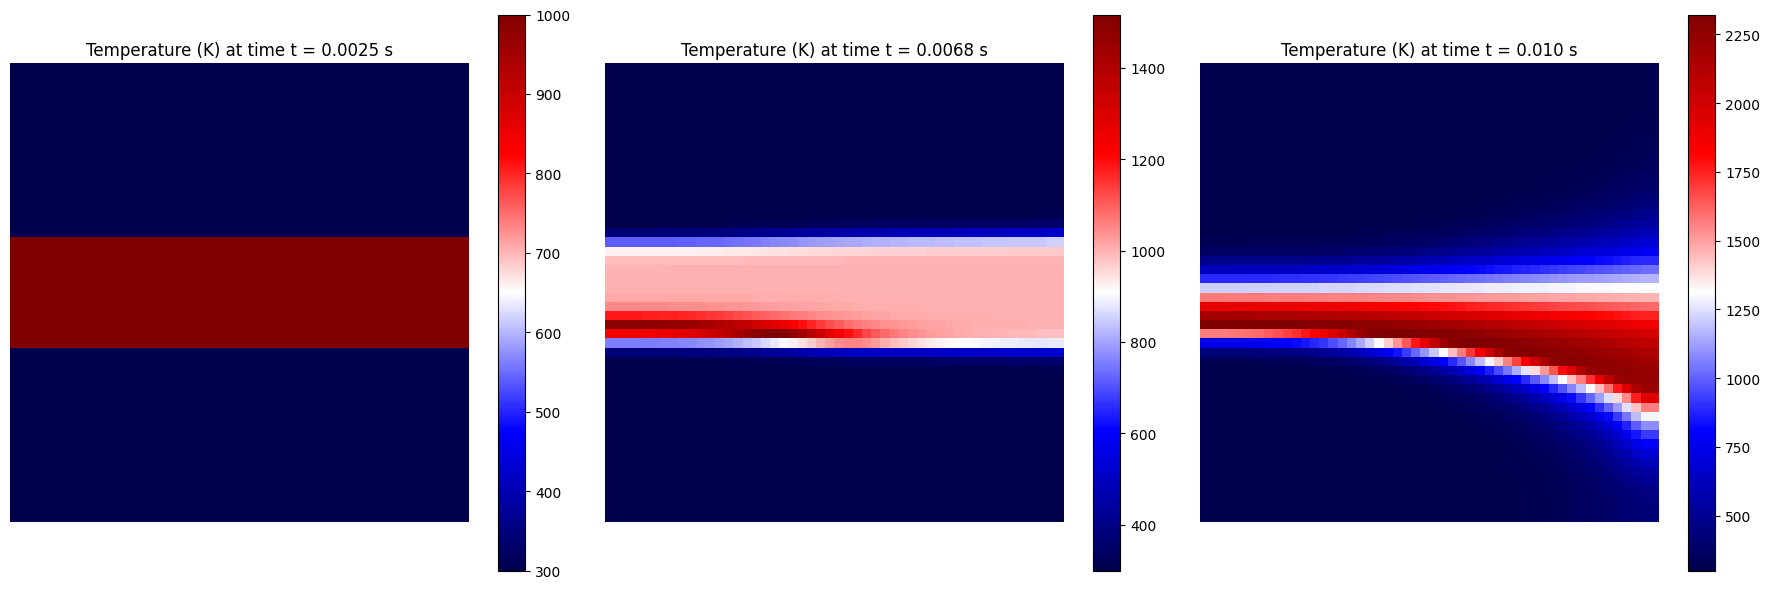

In [71]:
#Temperature change over time
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  

im14 = axs4[0].imshow(np.reshape(T_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"Temperature (K) at time t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(T_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"Temperature (K) at time t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(T_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"Temperature (K) at time t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

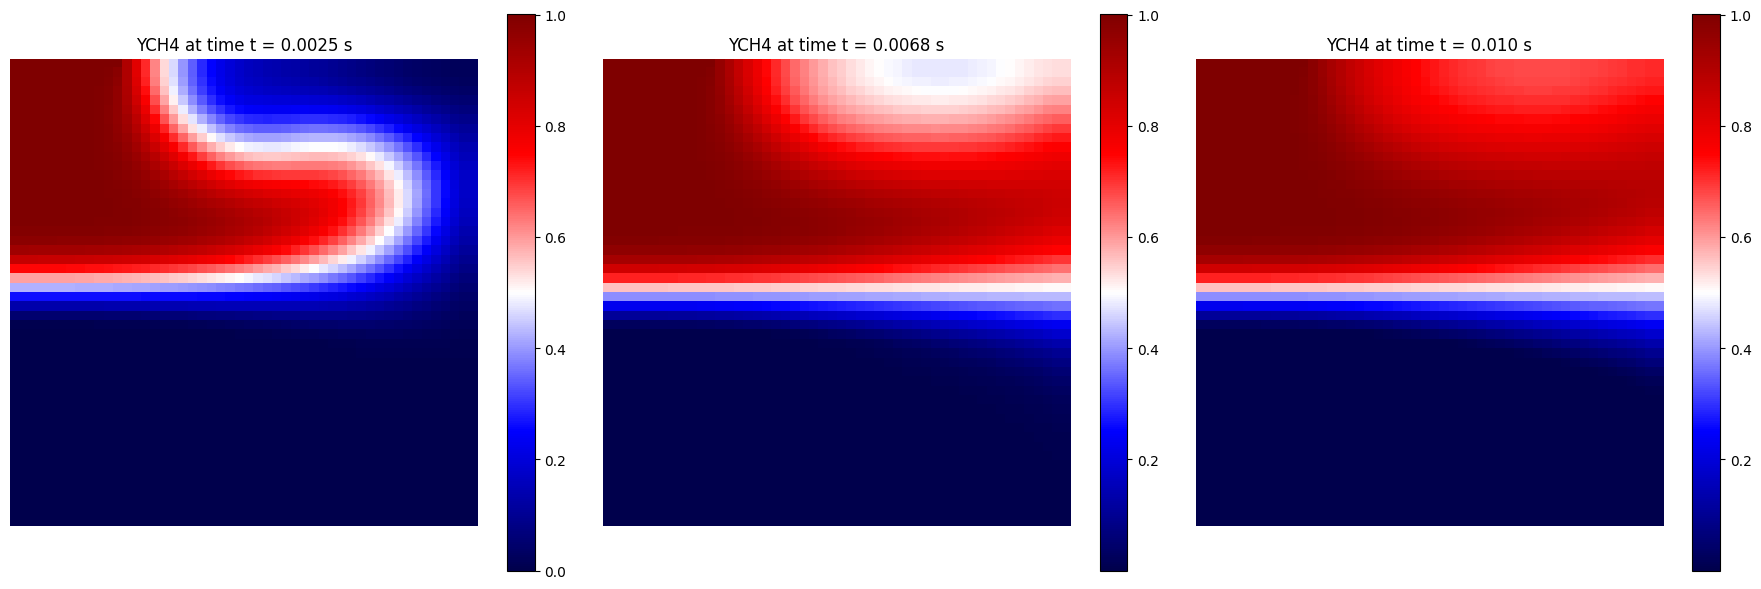

In [72]:
#Evolution of YCH4 over time
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  

im14 = axs4[0].imshow(np.reshape(YCH4_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCH4 at time t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YCH4_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCH4 at time t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YCH4_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCH4 at time t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

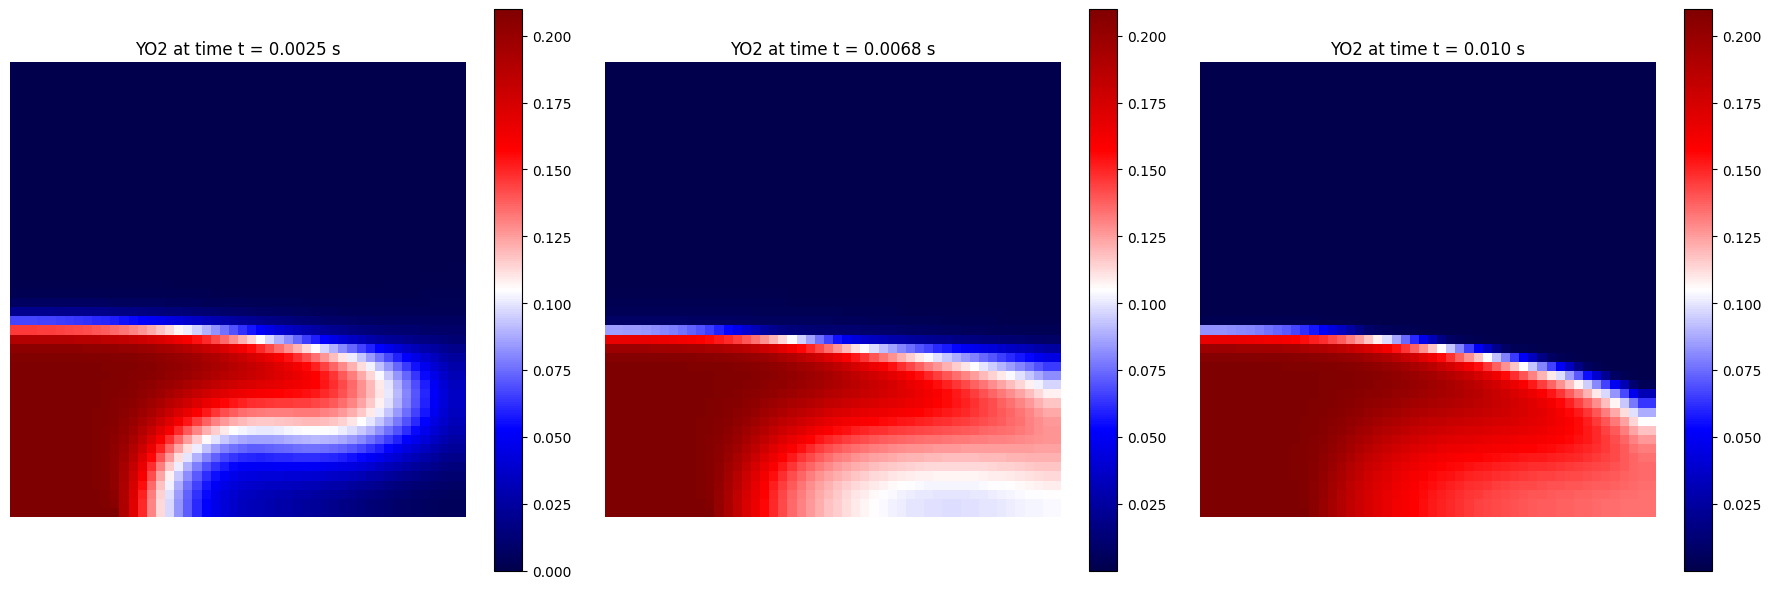

In [73]:
#Evolution of YO2 over time
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  

im14 = axs4[0].imshow(np.reshape(YO2_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YO2 at time t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YO2_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YO2 at time t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YO2_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YO2 at time t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

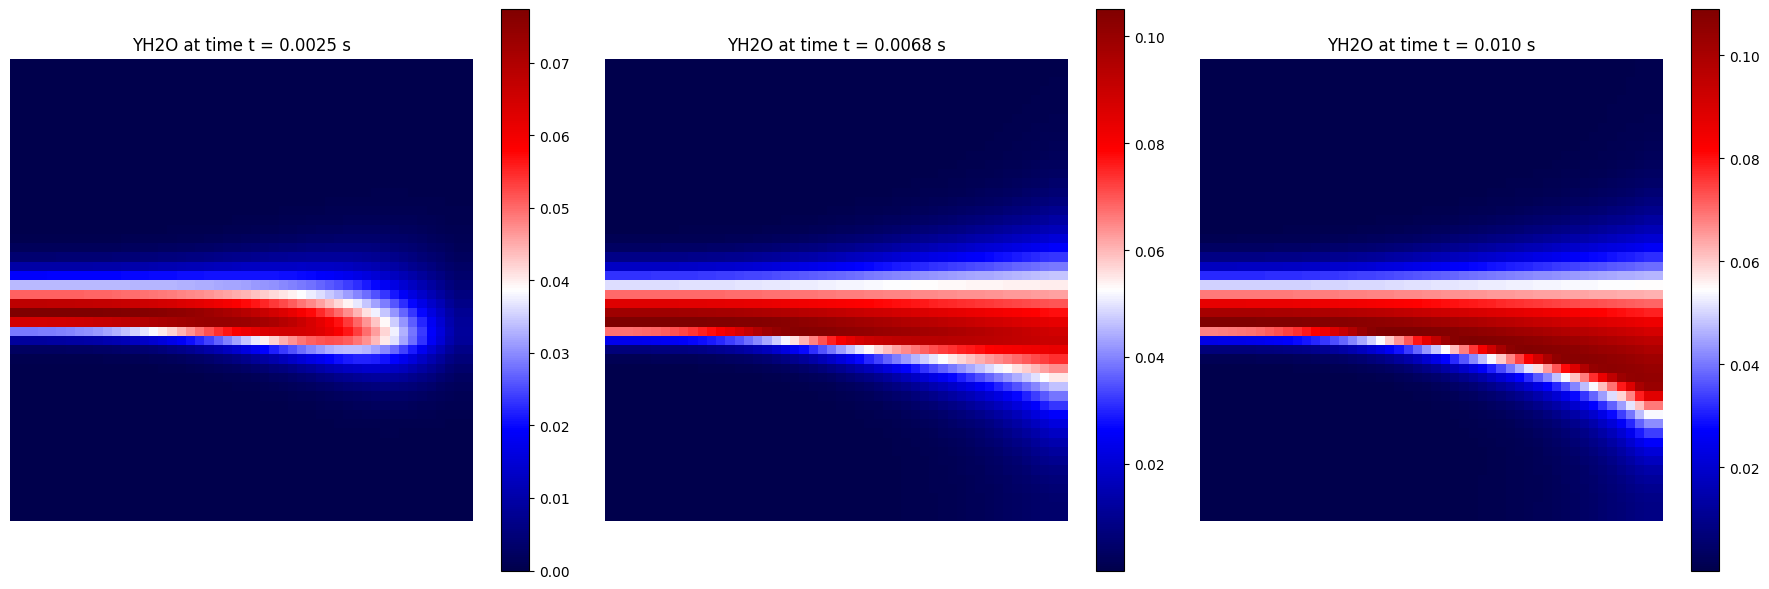

In [74]:
#Evolution of YH2O over time
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  

im14 = axs4[0].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YH2O at time t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YH2O at time t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YH2O at time t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

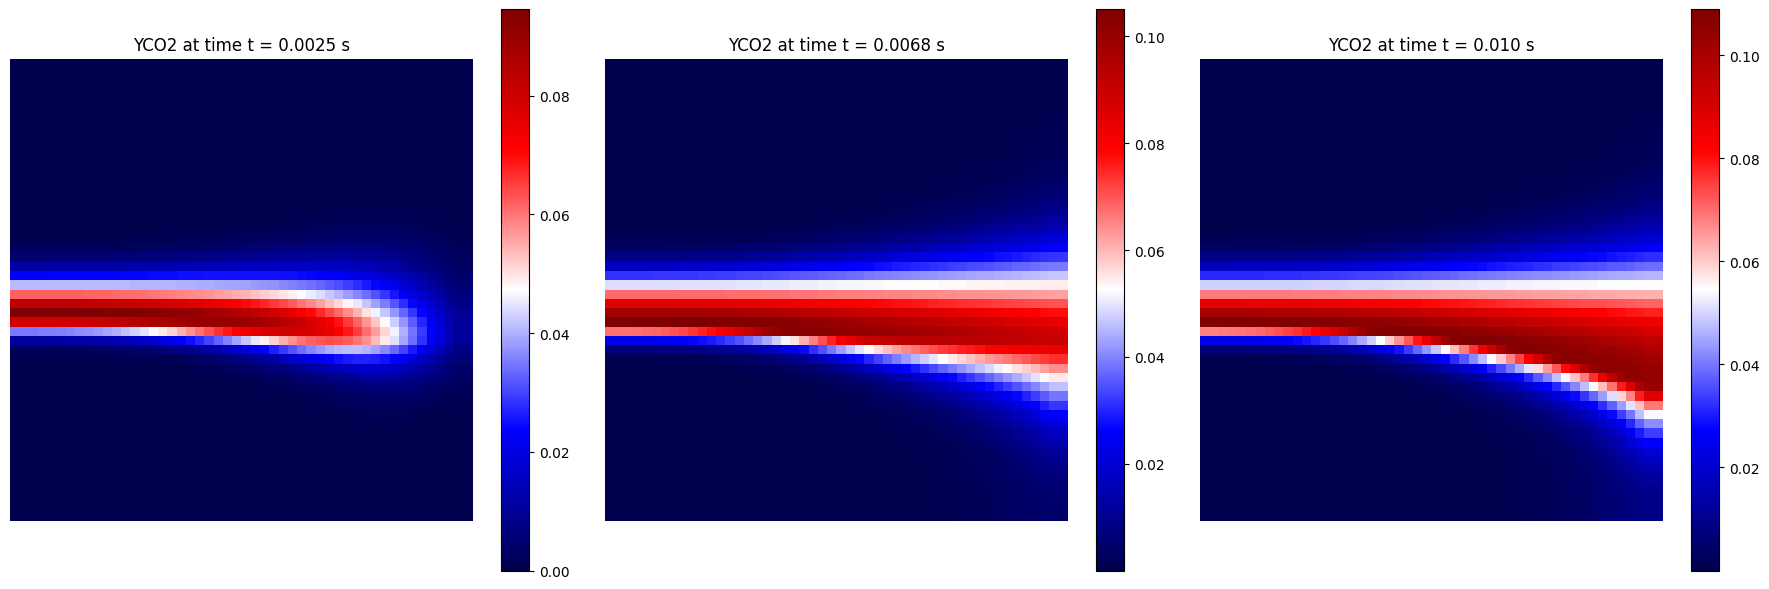

In [75]:
#Evolution of YCO2 over time
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  

im14 = axs4[0].imshow(np.reshape(YCO2_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCO2 at time t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCO2 at time t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCO2 at time t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

In [76]:
print("The maximum temperature reached during combustion is :", round(np.max(T_max),2), "°K, so ", round(np.max(T_max) - 273.15,2),"°C")

The maximum temperature reached during combustion is : 2322.27 °K, so  2049.12 °C


According to online resources, the temperature reached during methane combustion in air under real-world conditions is 1960 °C, meaning our value is slightly higher. This can be explained by several factors:

- We are operating under relatively ideal combustion conditions (the temperature is perfectly homogeneous at the start, we are considering perfectly pure air, and there are no residues of any kind), which can lead to a slight increase in the simulated temperature compared to the actual combustion temperature.

- It is difficult to precisely determine the steady-state temperature. This depends on the chosen precision for its determination. We considered that a pressure difference of more than 1e-7 between time t and time t+1 was sufficient to consider the steady state, but we could have extended the time, and therefore the precision, and perhaps obtained a slightly lower temperature than the one we found. The problem here is that our machines are not powerful enough to maintain such refinement over a long period of time.

# Conclusion

This project allowed us to become more familiar with the world of numerical simulation. Throughout the work, several difficulties were encountered:

- The limited power of our computers prevented us from performing fine spatial refinements, as computation times quickly became extremely long or even unmanageable. In particular, to determine the true steady-state time, it would have been ideal to simulate further in time. Unfortunately, our hardware limitations made this impossible unless we sacrificed spatial accuracy.

- Some questions were difficult to understand and therefore challenging to implement in code.

- The boundary conditions were sometimes tricky to handle and implement, especially for pressure in the Navier–Stokes equations.

- Determining $\Delta t_{chem}$ was also challenging because any value that was slightly too large caused the code to diverge.

- Pressure solving turned out to be the most delicate issue: every iterative method we tested eventually diverged or required an unreasonably long time to converge. Finding a reliable way to compute the pressure was rather difficult.

- To improve the work, several perspectives can be considered:

- With greater computational power, we could simulate longer times and refine the spatial grid more strongly, potentially obtaining better pressure results. With such computational resources, we might also have used an iterative method to solve the pressure equation, possibly achieving an even lower relative error than with a direct LU-type method.